In [1]:
import cobra
import time
import numpy as np
import more_itertools as mi
import multiprocessing as mp
import matplotlib.pyplot as plt

In [2]:
from cobra.flux_analysis import (
    single_gene_deletion, single_reaction_deletion, double_gene_deletion,
    double_reaction_deletion)

In [3]:
from cobra import Model, Reaction, Metabolite

In [4]:
cobra.Configuration().solver="cplex"

In [5]:
%%time
model=cobra.io.read_sbml_model("./iNovo_base_2022.xml")

CPU times: user 741 ms, sys: 18.6 ms, total: 760 ms
Wall time: 779 ms


In [6]:
model2=model.copy()

In [7]:
lista=['exC00031', 'exVA','expHBA' , 'exSA', 'exS',  'exPCA', 'exV', 'exFA', 'exGDK', 'exSDK', 'exSSGGE', 'exSRGGE', 'exRSGGE', 'exRRGGE']

In [8]:
glucosa=0
vanilico=1
singirico=3

# FUNCIONES

In [9]:
def creaSoportes(modelo,numSoportes,reacciones,valores):
    soportes=set()
    while len(soportes)<numSoportes:
        with modelo:
            for k in range(len(valores)):
                r=modelo.reactions[reacciones[k]]
                r.bounds=valores[k]
                    
            r2=np.random.choice(modelo.reactions)
            modelo.objective=r2
            
            sol=modelo.optimize(objective_sense="maximize")

            if sol.status=="optimal":
                sop=frozenset([j for j in range(len(sol.fluxes)) if abs(sol.fluxes[j])>10**-12])
                soportes.add(sop)
        
    return(soportes)

def identificaTipo(nombre):
    if "(" in nombre:
        indice1=nombre.index("(")
        nombre2=nombre[indice1+1:]
        indice2=nombre2.index(")")
        nombre3=nombre2[:indice2] 
        if " and " in nombre3:
            tipo="SOP"
        if " or " in nombre3:
            tipo="POS"
    else:
        tipo="SOP"
    return(tipo)

def toPOS(nombre,tope=3):

    productos=set()    
    tipo=identificaTipo(nombre)

    if tipo=="SOP":
        sumandos=nombre.split(" or ")
        for sumando in sumandos:
            if " and " in sumando:
                casos=sumando.split(" and ")
                miCaso=set()
                for caso in casos:
                    caso2=caso.replace("(","")
                    caso3=caso2.replace(")","")
                    caso4=caso3.replace(" ","")
                    miCaso.add(caso4)

                productos.add(frozenset(miCaso))
            else:
                productos.add(frozenset([sumando]))

        CS=set([frozenset()])
        for producto in productos:
            CS2=set()
            for C in CS:
                if len(set(C).intersection(producto))==0:
                    for a in producto:
                        C2=set(C.copy())
                        C2.add(a)
                        if len(C2)<=tope:
                            CS2.add(frozenset(C2))
                else:
                    CS2.add(C)
            CS=CS2

        CS3=set()
        for C in CS:
            bien=True
            for C2 in CS:
                if not C==C2 and C2.issubset(C):
                    bien=False
                    break
            if bien:
                CS3.add(C)
    else:
        CS2=set()
        productos = nombre.split(" and ")
        for producto in productos:
            CS=set()
            componentes=producto.split(" or ")
            for C in componentes:
                C2=C.replace("(","")
                C3=C2.replace(")","")
                C4=C3.replace(" ","")
                CS.add(C4)
            CS2.add(frozenset(CS))
        CS3=set()
        for C in CS2:
            bien=True
            for C2 in CS2:
                if not C==C2 and C2.issubset(C):
                    bien=False
                    break
            if bien:
                CS3.add(C)
    return(CS3)

def asociar(modelo,tope=4):
    verbose=False
    total=0
    asociados=dict()
    reacciones=dict()

    for num in range(len(modelo.reactions)):
        nombre=modelo.reactions[num].gene_reaction_rule
        CS3=toPOS(nombre,tope)
        k=0
        while k<=tope:
            mas=0
            nivel=set([C for C in CS3 if len(C)==k and not C==frozenset({''})])
            if len(nivel)>0:
                mios=set()
                for caso in nivel:
                    mio=set()
                    for a in caso:
                        mio.add(a)
                    mios.add(frozenset(mio))

                asociados[(modelo.reactions[num],k)]=mios

                for caso in mios:
                    if not caso in reacciones:
                        reacciones[caso]=set([modelo.reactions[num]])
                    else:
                        reacciones[caso].add(modelo.reactions[num])
                mas+=len(nivel)
            total+=mas
            k+=1    
        if verbose:
            print(num,len(modelo.reactions[num].genes),mas)

    return(asociados,reacciones)
    
    
def soporteG(soporte,tope,modelo=model2):
    sopG=set()
    for j in soporte:
        r=modelo.reactions[j]
        for k in range(1,tope+1):
            if (r,k) in asociados:
                sopG.update(asociados[(r,k)])

    sopG2=set()
    for caso in sopG:
        poner=True
        for caso2 in sopG:
            if not caso==caso2 and caso2.issubset(caso):
                poner=False
                break
        if poner:
            sopG2.add(caso)
    return(sopG2)

def chequea(inicio,fin):
    respuestas=set()
    for i in range(inicio,fin):
        if i<len(finales):
            C=finales[i]
            vale=True
            if C in powers:
                po=powers[C]
            else:
                po=set([frozenset(a) for a in mi.powerset(C) if len(a)>0])
                powers[C]=po

            if len(po.intersection(todosMCS))>0 or len(evitar.intersection(C))>0:
                vale=False

            if vale:
                for sop in misSoportes:
                    if len(po.intersection(sopG[sop]))==0:           
                        vale=False
                        break
            if vale:
                respuestas.add(C)

    return(respuestas)


In [10]:
def CSV2(modelo,tope,misReacciones,misValores,verbose,evita):
    global tiempos
    global todosMCS
    global evitar
    global misSoportes
    global listaMias
    global listaFinales
    global sopG
    
    global finales
    
    listaMias=[]
    salto=6
    
    evitar=evita
    listaMCS=[]
    listaMCS.append(set())
    
    listaCandidatos=[]
    listaCandidatos.append(set([frozenset()]))
    todosMCS=set()
    cutsets=[set()]
    candidatos=[set()]

    ts=0
    
    for i in range(1,tope+1):
        if i==1:            
            genes=set()
            cont=0
            for sop in misSoportes:
                if not sop in sopG:
                    sopG[sop]=soporteG(sop,tope,modelo)
                nuevos=[caso for caso in sopG[sop] if len(caso)==1 and len(evitar.intersection(caso))==0]
                if cont==0:
                    genes.update(nuevos)
                else:
                    genes=genes.intersection(nuevos)
                cont+=1
            if verbose:
                print(len(genes))
            descartados=set()
            CST=set()
            for caso in genes:
                if not caso in descartados:
                    with modelo:
                        for g in caso:
                            modelo.genes.get_by_id(g).knock_out()
                        for k in range(len(misValores)):
                            r=modelo.reactions[misReacciones[k]]
                            r.bounds=misValores[k]
                        modelo.objective=0
                        sol=modelo.slim_optimize(error_value=-1)
                        if sol==-1:
                            CST.add(caso)
                            todosMCS.add(caso)
                        else:
                            sol2=modelo.optimize()
                            sop=frozenset([j for j in range(len(modelo.reactions)) if abs(sol2.fluxes[j])>10**-8])
                            if not sop in sopG:
                                sopG[sop]=soporteG(sop,tope,modelo)
                                misSoportes.add(sop)
                            nuevos=[caso for caso in sopG[sop] if len(caso)==1]
                            descartados.update(genes.difference(nuevos))
            
            cutsets.append(CST)
            candidatos.append(genes.difference(CST))
            
            print("Final Fase 1 con",len(candidatos[1]),"candidatos y",len(cutsets[1]),"cutsets")

            print()
       
        ############################## Final Fase 1 ############################################
    
        else:
            print("Inicio de Fase",i,"con",len(misSoportes),"soportes")
            iMio=i
            
            ############################## Parte 1.- Berge #################################### 
            st1=time.time()
            CST2=set()
            lista=set([frozenset()])
            descartados=set()
            cont2=0
            long=dict()
            for sop in misSoportes:
                long[sop]=len(sopG[sop])
            sortedSupports= sorted(long.items(), key=lambda x:x[1])
            finales=set()
            
            for t in range(len(misSoportes)):
                ################ Para cada soporte #################
                item=sortedSupports[t]
                sop=item[0]
                lista2=set()
                for caso in lista:
                    sst=time.time()
                    if caso in powers:
                        po=powers[caso]
                    else:
                        po=set([frozenset(a) for a in mi.powerset(caso) if len(a)>0])
                        powers[caso]=po
                    esta=(len(po.intersection(sopG[sop]))>0)
                    ts+=(time.time()-sst)
                    if esta:
                        lista2.add(caso)
                    else:
                        for caso2 in sopG[sop]:
                            if len(caso.union(caso2))<iMio:
                                nuevo=caso.union(caso2)
                                lista2.add(nuevo)
                            if len(caso.union(caso2))==iMio:
                                nuevo=caso.union(caso2)
                                finales.add(nuevo)
                        
                
                lista4=set()
                for C in lista2:
                    sst=time.time()
                    if C in powers:
                        po2=powers[C]
                    else:
                        po2=set([frozenset(a) for a in mi.powerset(C) if len(a)>0])
                        powers[C]=po2
                    if len(po2.intersection(todosMCS))==0 and len(evitar.intersection(C))==0:
                        lista4.add(C)
                    ts+=(time.time()-sst)
                cont2+=1
                lista=lista4
                lista3=[C for C in lista if len(C)<i]
                if verbose:
                    print("Mal",len(lista3))
                if len(lista)>0 and len(lista3)==0:
                    break
                
            
                    #break
            ########################## He terminado de procesar los soportes ###############
            
            if verbose:
                print("Parte paralela")
            
            lista3=[C for C in lista if len(C)<i]
            
            
            
            misFinales=list(finales)
            if verbose:
                print("Total",len(misFinales))
            lista=set()
            numLista=10**6
            r=0
            while r*numLista<len(misFinales):
                maximo=(r+1)*10**6
                if len(misFinales)<maximo:
                    maximo=len(misFinales)
                finales=misFinales[r*numLista:maximo]
                if verbose:
                    print(r,"Finales",r*numLista,maximo)
                r+=1
                

                finales=list(finales)


                cpus=mp.cpu_count()
                cpus=8

                listas=[]

                k=0
                argus=[]
                num=int(np.floor(len(finales)/(cpus-1)))
                while k*num<len(finales):
                    argus.append((k*num,(k+1)*num))
                    k+=1

                with mp.Pool(processes=cpus) as mp_pool:
                    results=mp_pool.starmap(chequea,argus)

                for result in results:
                    lista.update(result)



            st1=time.time()-st1
            st2=time.time()
            
            cont2=1
            
            lista2=set()
            
            listaL=list(lista)
            if verbose:
                print(len(lista))
            
            i2=0
            while i2 < len(listaL):
                if verbose:
                    print(i2,len(listaL),len(listaL)-len(descartados))
                casos=[]
                
                contCasos=0
                for k in range(i2,len(listaL)):
                    if not listaL[k] in descartados:
                        casos.append(listaL[k])
                        contCasos+=1
                    if contCasos>=salto:
                        break
                i2=k+1
                
                cont3=0
                if len(casos) > 0:
                    
                    with modelo:
                        for caso in casos:
                            descartados.add(caso)
                            for g in caso:
                                modelo.genes.get_by_id(g).knock_out()
                        
                        for k in range(len(misValores)):
                            r=modelo.reactions[misReacciones[k]]
                            r.bounds=misValores[k]
                        
                        sol=modelo.slim_optimize(error_value=-1)
                        if sol==-1:
                            for caso in casos:
                                lista2.add(caso)
                        else:
                            sol2=modelo.optimize()
                            sop=frozenset([j for j in range(len(modelo.reactions)) if abs(sol2.fluxes[j])>10**-8])
                            if not sop in sopG:
                                sopG[sop]=soporteG(sop,tope,modelo)
                                misSoportes.add(sop)
                            nuevos=[caso for caso in sopG[sop] if len(caso)>0]
                            for C in lista.difference(descartados): 
                                sst=time.time()
                                if C in powers:
                                    sub=powers[C]
                                else:
                                    sub=set([frozenset(a) for a in mi.powerset(C) if len(a)>0])
                                    powers[C]=sub
                                if len(sub.intersection(sopG[sop]))==0:
                                    descartados.add(C)
                                ts+=(time.time()-sst)
                if verbose:
                    print(cont2,i2,contCasos,len(lista.difference(descartados)))
                cont2+=1
            if verbose:
                print()
                print("Lista2",len(lista2))
                print()
            
            cutsetsT=set()
            
            st2=time.time()-st2
            st3=time.time()
            
            if verbose:
                print("Sin salto")
            descartados=set()
            cont=0
            for caso in lista2:
                if verbose:
                    print(len(lista2),len(lista2.difference(descartados)),len(cutsetsT))
                cont+=1
                if not caso in descartados:
                    descartados.add(caso)
                    with modelo:
                        for g in caso:
                            modelo.genes.get_by_id(g).knock_out()
                        for k in range(len(misValores)):
                            r=modelo.reactions[misReacciones[k]]
                            r.bounds=misValores[k]

                        sol=modelo.slim_optimize(error_value=-1)
                        if sol==-1:
                            cutsetsT.add(caso)
                            todosMCS.add(caso)
                        else:
                            sol2=modelo.optimize()
                            sop=frozenset([j for j in range(len(modelo.reactions)) if abs(sol2.fluxes[j])>10**-8])
                            if not sop in sopG:
                                sopG[sop]=soporteG(sop,tope,modelo)
                                misSoportes.add(sop)
                            nuevos=[caso for caso in sopG[sop] if len(caso)>0]
                            for C in lista2.difference(descartados): 
                                sst=time.time()
                                sub=set([frozenset(a) for a in mi.powerset(C) if len(a)>0])
                                if len(sub.intersection(sopG[sop]))==0:
                                    descartados.add(C)
                                ts+=(time.time()-sst)
                    if verbose:
                        print(cont,len(lista2.difference(descartados)),len(cutsetsT))     
                
            st3=time.time()-st3

            cutsets.append(cutsetsT)
        if i>1:
            tiempos.append([st1,st2,st3])
    
    #print(ts)
    return(cutsets)
                        

# MODELO




Los bioproductos actualmente permitidos para probar son C00489 (glutarato), C06098 (zeaxantina), C02480 (ácido mucónico cis-cis), C00158 (citrato), C00163 (propanoato), C00084 (acetaldehído), C00116 (glicerol), C00246 (butanoato), C00823 (1-hexadecanol), C00146 (fenol), C00086 (urea), C00033 (acetato) y C00189 (etanolamina).

* glutarato

In [11]:
bioproduct='C00489'
model3=cobra.io.read_sbml_model("./iNovo_engineered_2022.xml")

name='Export_'+bioproduct

reaction = Reaction(name)
reaction.compartment = 'e'
reaction.lower_bound = 0.  
reaction.upper_bound = 1000.  
reaction.add_metabolites({
    model3.metabolites.get_by_id(bioproduct): -1.0,
})
model3.add_reactions([reaction])

for i in range(2,len(lista)):
    r=model3.reactions.get_by_id("EX_"+lista[i])
    r.knock_out()
r=model3.reactions.get_by_id("EX_"+lista[glucosa])
r.lower_bound=0
r=model3.reactions.get_by_id("EX_"+lista[vanilico])
r.lower_bound=-5

for j in range(len(model3.reactions)):
    r=model3.reactions[j]
    if r.id=="biomass":
        biomass=j
    if r.id==name:
        objetivo=j

model3.objective=model3.reactions[biomass]
model3.objective_direction="max"
max_bio=model3.slim_optimize()

misReacciones, misValores = [biomass,objetivo],[[0.1,1000],[0,0]]

tope=4
asociados,reacciones=asociar(model3,tope)
sopG=dict()
misSoportes=creaSoportes(model3,tope,misReacciones,misValores)
for sop in misSoportes:
    sopG[sop]=soporteG(sop,tope,model3)
    
tiempos=[]
powers=dict()
CS1=CSV2(model3,tope,misReacciones,misValores,False,set())
print()
print('Estrategias para '+ model3.metabolites.get_by_id(bioproduct).name+ ':')

for i in range(len(CS1)):
    for caso in CS1[i]:
        with model3:
            for g in caso:
                model3.genes.get_by_id(g).knock_out()
            
            model3.objective=model3.reactions[biomass]
            model3.objective_direction="max"
            sol1=model3.slim_optimize(error_value=-1)
            if sol1>0:
                model3.objective=model3.reactions[objetivo]
                model3.objective_direction="min"
                model3.reactions[biomass].bounds=[0.1,1000]
                sol2=model3.slim_optimize(error_value=-1)
                if sol2>0:
                    model3.reactions[biomass].lower_bound=sol1
                    model3.objective=model3.reactions[objetivo]
                    model3.objective_direction="min"
                    sol3=model3.slim_optimize()
                    print()
                    print('- '+ str(caso))
                    print()
                    print('     Max biomass: ',sol1)
                    print('     Min bioproduct: ',sol2)
                    print('     Min bioproduct with max growth: ',sol3)
                    print()


Final Fase 1 con 8 candidatos y 174 cutsets

Inicio de Fase 2 con 8 soportes
Inicio de Fase 3 con 25 soportes
Inicio de Fase 4 con 59 soportes

Estrategias para Glutarate:

- frozenset({'SARO_RS09275', 'SARO_RS05890', 'SARO_RS04510', 'SARO_RS16100'})

     Max biomass:  0.5496587918743345
     Min bioproduct:  0.12677603851363983
     Min bioproduct with max growth:  0.696826338390224


- frozenset({'SARO_RS05890', 'SARO_RS04510', 'SARO_RS16100', 'SARO_RS09260'})

     Max biomass:  0.5496587918740113
     Min bioproduct:  0.12677603851318509
     Min bioproduct with max growth:  0.6968263383882913


- frozenset({'SARO_RS05890', 'SARO_RS09270', 'SARO_RS16100', 'SARO_RS04510'})

     Max biomass:  0.549658791874011
     Min bioproduct:  0.1267760385129577
     Min bioproduct with max growth:  0.6968263383901103



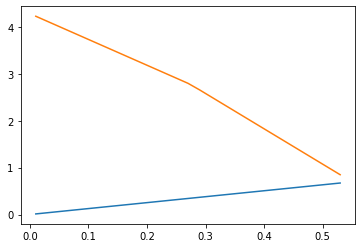

In [12]:
caso=frozenset({'SARO_RS09275', 'SARO_RS05890', 'SARO_RS04510', 'SARO_RS16100'})
xs=[]
y1s=[]
y2s=[]

bio=0.01
while bio <max_bio:
    with model3:
        for g in caso:
            model3.genes.get_by_id(g).knock_out()
        model3.reactions[biomass].bounds=[bio,bio]
        model3.objective=model3.reactions[objetivo]
        model3.objective_direction="min"
        sol1=model3.slim_optimize()
        model3.objective_direction="max"
        sol2=model3.slim_optimize()
        xs.append(bio)
        y1s.append(sol1)
        y2s.append(sol2)
        bio+=0.02
        
plt.plot(xs,y1s)
plt.plot(xs,y2s)

* citrato

In [13]:
bioproduct='C00158'
model3=cobra.io.read_sbml_model("./iNovo_engineered_2022.xml")

name='Export_'+bioproduct

reaction = Reaction(name)
reaction.compartment = 'e'
reaction.lower_bound = 0.  
reaction.upper_bound = 1000.  
reaction.add_metabolites({
    model3.metabolites.get_by_id(bioproduct): -1.0,
})
model3.add_reactions([reaction])

for i in range(2,len(lista)):
    r=model3.reactions.get_by_id("EX_"+lista[i])
    r.knock_out()
r=model3.reactions.get_by_id("EX_"+lista[glucosa])
r.lower_bound=0
r=model3.reactions.get_by_id("EX_"+lista[vanilico])
r.lower_bound=-5

for j in range(len(model3.reactions)):
    r=model3.reactions[j]
    if r.id=="biomass":
        biomass=j
    if r.id==name:
        objetivo=j

model3.objective=model3.reactions[biomass]
model3.objective_direction="max"
max_bio=model3.slim_optimize()

misReacciones, misValores = [biomass,objetivo],[[0.1,1000],[0,0]]

tope=4
asociados,reacciones=asociar(model3,tope)
sopG=dict()
misSoportes=creaSoportes(model3,tope,misReacciones,misValores)
for sop in misSoportes:
    sopG[sop]=soporteG(sop,tope,model3)
    
tiempos=[]
powers=dict()
CS1=CSV2(model3,tope,misReacciones,misValores,False,set())
print()
print('Estrategias para '+ model3.metabolites.get_by_id(bioproduct).name+ ':')

for i in range(len(CS1)):
    for caso in CS1[i]:
        with model3:
            for g in caso:
                model3.genes.get_by_id(g).knock_out()
            
            model3.objective=model3.reactions[biomass]
            model3.objective_direction="max"
            sol1=model3.slim_optimize(error_value=-1)
            if sol1>0:
                model3.objective=model3.reactions[objetivo]
                model3.objective_direction="min"
                model3.reactions[biomass].bounds=[0.1,1000]
                sol2=model3.slim_optimize(error_value=-1)
                if sol2>0:
                    model3.reactions[biomass].lower_bound=sol1
                    model3.objective=model3.reactions[objetivo]
                    model3.objective_direction="min"
                    sol3=model3.slim_optimize()
                    print()
                    print('- '+ str(caso))
                    print()
                    print('     Max biomass: ',sol1)
                    print('     Min bioproduct: ',sol2)
                    print('     Min bioproduct with max growth: ',sol3)
                    print()


Final Fase 1 con 13 candidatos y 174 cutsets

Inicio de Fase 2 con 12 soportes
Inicio de Fase 3 con 31 soportes
Inicio de Fase 4 con 73 soportes

Estrategias para Citrate:

- frozenset({'SARO_RS09275', 'SARO_RS05890', 'SARO_RS04510', 'SARO_RS16100'})

     Max biomass:  0.5445311714887839
     Min bioproduct:  0.19873000631775994
     Min bioproduct with max growth:  1.0821324142746107


- frozenset({'SARO_RS05890', 'SARO_RS04510', 'SARO_RS16100', 'SARO_RS09260'})

     Max biomass:  0.5445311714887784
     Min bioproduct:  0.19873000631935156
     Min bioproduct with max growth:  1.0821324142724507


- frozenset({'SARO_RS05890', 'SARO_RS09270', 'SARO_RS16100', 'SARO_RS04510'})

     Max biomass:  0.5445311714887968
     Min bioproduct:  0.19873000631696414
     Min bioproduct with max growth:  1.0821324142740423



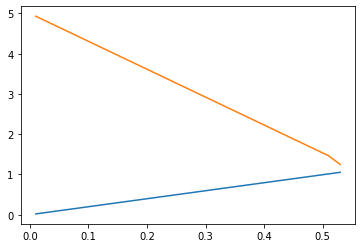

In [14]:
caso=frozenset({'SARO_RS09275', 'SARO_RS05890', 'SARO_RS04510', 'SARO_RS16100'})
xs=[]
y1s=[]
y2s=[]

bio=0.01
while bio <max_bio:
    with model3:
        for g in caso:
            model3.genes.get_by_id(g).knock_out()
        model3.reactions[biomass].bounds=[bio,bio]
        model3.objective=model3.reactions[objetivo]
        model3.objective_direction="min"
        sol1=model3.slim_optimize()
        model3.objective_direction="max"
        sol2=model3.slim_optimize()
        xs.append(bio)
        y1s.append(sol1)
        y2s.append(sol2)
        bio+=0.02
        
plt.plot(xs,y1s)
plt.plot(xs,y2s)

* propanato

In [15]:
bioproduct='C00163'
model3=cobra.io.read_sbml_model("./iNovo_engineered_2022.xml")

name='Export_'+bioproduct

reaction = Reaction(name)
reaction.compartment = 'e'
reaction.lower_bound = 0.  
reaction.upper_bound = 1000.  
reaction.add_metabolites({
    model3.metabolites.get_by_id(bioproduct): -1.0,
})
model3.add_reactions([reaction])

for i in range(2,len(lista)):
    r=model3.reactions.get_by_id("EX_"+lista[i])
    r.knock_out()
r=model3.reactions.get_by_id("EX_"+lista[glucosa])
r.lower_bound=0
r=model3.reactions.get_by_id("EX_"+lista[vanilico])
r.lower_bound=-5

for j in range(len(model3.reactions)):
    r=model3.reactions[j]
    if r.id=="biomass":
        biomass=j
    if r.id==name:
        objetivo=j

model3.objective=model3.reactions[biomass]
model3.objective_direction="max"
max_bio=model3.slim_optimize()

misReacciones, misValores = [biomass,objetivo],[[0.1,1000],[0,0]]

tope=4
asociados,reacciones=asociar(model3,tope)
sopG=dict()
misSoportes=creaSoportes(model3,tope,misReacciones,misValores)
for sop in misSoportes:
    sopG[sop]=soporteG(sop,tope,model3)
    
tiempos=[]
powers=dict()
CS1=CSV2(model3,tope,misReacciones,misValores,False,set())
print()
print('Estrategias para '+ model3.metabolites.get_by_id(bioproduct).name+ ':')

for i in range(len(CS1)):
    for caso in CS1[i]:
        with model3:
            for g in caso:
                model3.genes.get_by_id(g).knock_out()
            
            model3.objective=model3.reactions[biomass]
            model3.objective_direction="max"
            sol1=model3.slim_optimize(error_value=-1)
            if sol1>0:
                model3.objective=model3.reactions[objetivo]
                model3.objective_direction="min"
                model3.reactions[biomass].bounds=[0.1,1000]
                sol2=model3.slim_optimize(error_value=-1)
                if sol2>0:
                    model3.reactions[biomass].lower_bound=sol1
                    model3.objective=model3.reactions[objetivo]
                    model3.objective_direction="min"
                    sol3=model3.slim_optimize()
                    print()
                    print('- '+ str(caso))
                    print()
                    print('     Max biomass: ',sol1)
                    print('     Min bioproduct: ',sol2)
                    print('     Min bioproduct with max growth: ',sol3)
                    print()


Final Fase 1 con 9 candidatos y 174 cutsets

Inicio de Fase 2 con 11 soportes
Inicio de Fase 3 con 34 soportes
Inicio de Fase 4 con 69 soportes

Estrategias para Propanoate:

- frozenset({'SARO_RS14745'})

     Max biomass:  0.30420076812951796
     Min bioproduct:  1.3787015633026047
     Min bioproduct with max growth:  4.194020745777183


- frozenset({'SARO_RS06355'})

     Max biomass:  0.5538335357903044
     Min bioproduct:  0.2346674600268983
     Min bioproduct with max growth:  1.299667091210864


- frozenset({'SARO_RS11365', 'SARO_RS02790', 'SARO_RS09485', 'SARO_RS02165'})

     Max biomass:  0.46681843684954266
     Min bioproduct:  0.5129343769866637
     Min bioproduct with max growth:  2.3944624588891656


- frozenset({'SARO_RS02790', 'SARO_RS02165', 'SARO_RS09480', 'SARO_RS13605'})

     Max biomass:  0.46681843684947427
     Min bioproduct:  0.5129343769889374
     Min bioproduct with max growth:  2.3944624588833676


- frozenset({'SARO_RS11365', 'SARO_RS02790', 'SARO_R

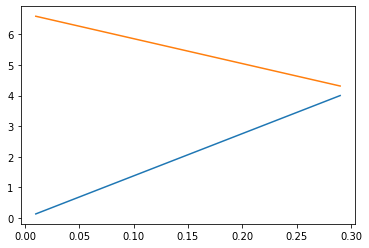

In [16]:
caso=frozenset({'SARO_RS14745'})
xs=[]
y1s=[]
y2s=[]

bio=0.01
while bio <max_bio:
    with model3:
        for g in caso:
            model3.genes.get_by_id(g).knock_out()
        model3.reactions[biomass].bounds=[bio,bio]
        model3.objective=model3.reactions[objetivo]
        model3.objective_direction="min"
        sol1=model3.slim_optimize()
        model3.objective_direction="max"
        sol2=model3.slim_optimize()
        xs.append(bio)
        y1s.append(sol1)
        y2s.append(sol2)
        bio+=0.02
        
plt.plot(xs,y1s)
plt.plot(xs,y2s)

* acetaldehido

In [17]:
bioproduct='C00084'
model3=cobra.io.read_sbml_model("./iNovo_engineered_2022.xml")

name='Export_'+bioproduct

reaction = Reaction(name)
reaction.compartment = 'e'
reaction.lower_bound = 0.  
reaction.upper_bound = 1000.  
reaction.add_metabolites({
    model3.metabolites.get_by_id(bioproduct): -1.0,
})
model3.add_reactions([reaction])

for i in range(2,len(lista)):
    r=model3.reactions.get_by_id("EX_"+lista[i])
    r.knock_out()
r=model3.reactions.get_by_id("EX_"+lista[glucosa])
r.lower_bound=0
r=model3.reactions.get_by_id("EX_"+lista[vanilico])
r.lower_bound=-5

for j in range(len(model3.reactions)):
    r=model3.reactions[j]
    if r.id=="biomass":
        biomass=j
    if r.id==name:
        objetivo=j

model3.objective=model3.reactions[biomass]
model3.objective_direction="max"
max_bio=model3.slim_optimize()

misReacciones, misValores = [biomass,objetivo],[[0.1,1000],[0,0]]

tope=4
asociados,reacciones=asociar(model3,tope)
sopG=dict()
misSoportes=creaSoportes(model3,tope,misReacciones,misValores)
for sop in misSoportes:
    sopG[sop]=soporteG(sop,tope,model3)
    
tiempos=[]
powers=dict()
CS1=CSV2(model3,tope,misReacciones,misValores,False,set())
print()
print('Estrategias para '+ model3.metabolites.get_by_id(bioproduct).name+ ':')

for i in range(len(CS1)):
    for caso in CS1[i]:
        with model3:
            for g in caso:
                model3.genes.get_by_id(g).knock_out()
            
            model3.objective=model3.reactions[biomass]
            model3.objective_direction="max"
            sol1=model3.slim_optimize(error_value=-1)
            if sol1>0:
                model3.objective=model3.reactions[objetivo]
                model3.objective_direction="min"
                model3.reactions[biomass].bounds=[0.1,1000]
                sol2=model3.slim_optimize(error_value=-1)
                if sol2>0:
                    model3.reactions[biomass].lower_bound=sol1
                    model3.objective=model3.reactions[objetivo]
                    model3.objective_direction="min"
                    sol3=model3.slim_optimize()
                    print()
                    print('- '+ str(caso))
                    print()
                    print('     Max biomass: ',sol1)
                    print('     Min bioproduct: ',sol2)
                    print('     Min bioproduct with max growth: ',sol3)
                    print()


Final Fase 1 con 13 candidatos y 174 cutsets

Inicio de Fase 2 con 12 soportes
Inicio de Fase 3 con 31 soportes
Inicio de Fase 4 con 75 soportes

Estrategias para Acetaldehyde:

- frozenset({'SARO_RS14745'})

     Max biomass:  0.42515379162881634
     Min bioproduct:  0.9110967255395508
     Min bioproduct with max growth:  3.8735559807475965


- frozenset({'SARO_RS11270'})

     Max biomass:  0.5976082576303539
     Min bioproduct:  0.10507099908425993
     Min bioproduct with max growth:  0.6279129668991725


- frozenset({'SARO_RS14515'})

     Max biomass:  0.3525861941576192
     Min bioproduct:  1.3549638997728295
     Min bioproduct with max growth:  4.777410420494847


- frozenset({'SARO_RS13605', 'SARO_RS05490'})

     Max biomass:  0.586786088109059
     Min bioproduct:  0.13995797662431125
     Min bioproduct with max growth:  0.8212539360264021


- frozenset({'SARO_RS11365', 'SARO_RS05490'})

     Max biomass:  0.5867860881099679
     Min bioproduct:  0.13995797662544812
  

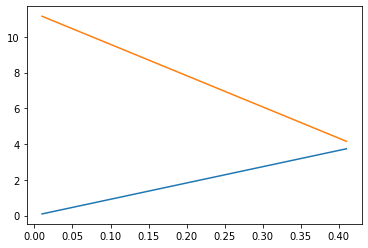

In [18]:
caso=frozenset({'SARO_RS14745'})
xs=[]
y1s=[]
y2s=[]

bio=0.01
while bio <max_bio:
    with model3:
        for g in caso:
            model3.genes.get_by_id(g).knock_out()
        model3.reactions[biomass].bounds=[bio,bio]
        model3.objective=model3.reactions[objetivo]
        model3.objective_direction="min"
        sol1=model3.slim_optimize()
        model3.objective_direction="max"
        sol2=model3.slim_optimize()
        xs.append(bio)
        y1s.append(sol1)
        y2s.append(sol2)
        bio+=0.02
        
plt.plot(xs,y1s)
plt.plot(xs,y2s)

* glicerol

In [19]:
bioproduct='C00116'
model3=cobra.io.read_sbml_model("./iNovo_engineered_2022.xml")

name='Export_'+bioproduct

reaction = Reaction(name)
reaction.compartment = 'e'
reaction.lower_bound = 0.  
reaction.upper_bound = 1000.  
reaction.add_metabolites({
    model3.metabolites.get_by_id(bioproduct): -1.0,
})
model3.add_reactions([reaction])

for i in range(2,len(lista)):
    r=model3.reactions.get_by_id("EX_"+lista[i])
    r.knock_out()
r=model3.reactions.get_by_id("EX_"+lista[glucosa])
r.lower_bound=0
r=model3.reactions.get_by_id("EX_"+lista[vanilico])
r.lower_bound=-5

for j in range(len(model3.reactions)):
    r=model3.reactions[j]
    if r.id=="biomass":
        biomass=j
    if r.id==name:
        objetivo=j

model3.objective=model3.reactions[biomass]
model3.objective_direction="max"
max_bio=model3.slim_optimize()

misReacciones, misValores = [biomass,objetivo],[[0.1,1000],[0,0]]

tope=4
asociados,reacciones=asociar(model3,tope)
sopG=dict()
misSoportes=creaSoportes(model3,tope,misReacciones,misValores)
for sop in misSoportes:
    sopG[sop]=soporteG(sop,tope,model3)
    
tiempos=[]
powers=dict()
CS1=CSV2(model3,tope,misReacciones,misValores,False,set())
print()
print('Estrategias para '+ model3.metabolites.get_by_id(bioproduct).name+ ':')

for i in range(len(CS1)):
    for caso in CS1[i]:
        with model3:
            for g in caso:
                model3.genes.get_by_id(g).knock_out()
            
            model3.objective=model3.reactions[biomass]
            model3.objective_direction="max"
            sol1=model3.slim_optimize(error_value=-1)
            if sol1>0:
                model3.objective=model3.reactions[objetivo]
                model3.objective_direction="min"
                model3.reactions[biomass].bounds=[0.1,1000]
                sol2=model3.slim_optimize(error_value=-1)
                if sol2>0:
                    model3.reactions[biomass].lower_bound=sol1
                    model3.objective=model3.reactions[objetivo]
                    model3.objective_direction="min"
                    sol3=model3.slim_optimize()
                    print()
                    print('- '+ str(caso))
                    print()
                    print('     Max biomass: ',sol1)
                    print('     Min bioproduct: ',sol2)
                    print('     Min bioproduct with max growth: ',sol3)
                    print()


Final Fase 1 con 6 candidatos y 174 cutsets

Inicio de Fase 2 con 9 soportes
Inicio de Fase 3 con 25 soportes
Inicio de Fase 4 con 61 soportes

Estrategias para Glycerol:

- frozenset({'SARO_RS11365', 'SARO_RS02790', 'SARO_RS09485', 'SARO_RS02165'})

     Max biomass:  0.45546984066546947
     Min bioproduct:  0.5396216104025838
     Min bioproduct with max growth:  2.4578044159830363


- frozenset({'SARO_RS02790', 'SARO_RS02165', 'SARO_RS09480', 'SARO_RS13605'})

     Max biomass:  0.45546984066546947
     Min bioproduct:  0.5396216104051064
     Min bioproduct with max growth:  2.4578044159786714


- frozenset({'SARO_RS11365', 'SARO_RS02790', 'SARO_RS02165', 'SARO_RS09490'})

     Max biomass:  0.4554698406654729
     Min bioproduct:  0.539621610406698
     Min bioproduct with max growth:  2.4578044159767387


- frozenset({'SARO_RS09250', 'SARO_RS11365', 'SARO_RS09485', 'SARO_RS02165'})

     Max biomass:  0.4554698406654717
     Min bioproduct:  0.539621610410336
     Min bioproduct

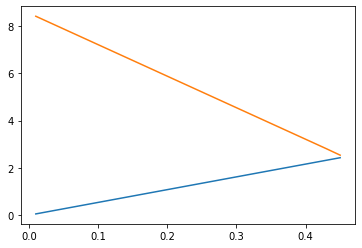

In [20]:
caso=frozenset({'SARO_RS02790', 'SARO_RS12945', 'SARO_RS13605', 'SARO_RS02165'})
xs=[]
y1s=[]
y2s=[]

bio=0.01
while bio <max_bio:
    with model3:
        for g in caso:
            model3.genes.get_by_id(g).knock_out()
        model3.reactions[biomass].bounds=[bio,bio]
        model3.objective=model3.reactions[objetivo]
        model3.objective_direction="min"
        sol1=model3.slim_optimize()
        model3.objective_direction="max"
        sol2=model3.slim_optimize()
        xs.append(bio)
        y1s.append(sol1)
        y2s.append(sol2)
        bio+=0.02
        
plt.plot(xs,y1s)
plt.plot(xs,y2s)

* butanoato

In [21]:
bioproduct='C00246'
model3=cobra.io.read_sbml_model("./iNovo_engineered_2022.xml")

name='Export_'+bioproduct

reaction = Reaction(name)
reaction.compartment = 'e'
reaction.lower_bound = 0.  
reaction.upper_bound = 1000.  
reaction.add_metabolites({
    model3.metabolites.get_by_id(bioproduct): -1.0,
})
model3.add_reactions([reaction])

for i in range(2,len(lista)):
    r=model3.reactions.get_by_id("EX_"+lista[i])
    r.knock_out()
r=model3.reactions.get_by_id("EX_"+lista[glucosa])
r.lower_bound=0
r=model3.reactions.get_by_id("EX_"+lista[vanilico])
r.lower_bound=-5

for j in range(len(model3.reactions)):
    r=model3.reactions[j]
    if r.id=="biomass":
        biomass=j
    if r.id==name:
        objetivo=j

model3.objective=model3.reactions[biomass]
model3.objective_direction="max"
max_bio=model3.slim_optimize()

misReacciones, misValores = [biomass,objetivo],[[0.1,1000],[0,0]]

tope=4
asociados,reacciones=asociar(model3,tope)
sopG=dict()
misSoportes=creaSoportes(model3,tope,misReacciones,misValores)
for sop in misSoportes:
    sopG[sop]=soporteG(sop,tope,model3)
    
tiempos=[]
powers=dict()
CS1=CSV2(model3,tope,misReacciones,misValores,False,set())
print()
print('Estrategias para '+ model3.metabolites.get_by_id(bioproduct).name+ ':')

for i in range(len(CS1)):
    for caso in CS1[i]:
        with model3:
            for g in caso:
                model3.genes.get_by_id(g).knock_out()
            
            model3.objective=model3.reactions[biomass]
            model3.objective_direction="max"
            sol1=model3.slim_optimize(error_value=-1)
            if sol1>0:
                model3.objective=model3.reactions[objetivo]
                model3.objective_direction="min"
                model3.reactions[biomass].bounds=[0.1,1000]
                sol2=model3.slim_optimize(error_value=-1)
                if sol2>0:
                    model3.reactions[biomass].lower_bound=sol1
                    model3.objective=model3.reactions[objetivo]
                    model3.objective_direction="min"
                    sol3=model3.slim_optimize()
                    print()
                    print('- '+ str(caso))
                    print()
                    print('     Max biomass: ',sol1)
                    print('     Min bioproduct: ',sol2)
                    print('     Min bioproduct with max growth: ',sol3)
                    print()


Final Fase 1 con 10 candidatos y 174 cutsets

Inicio de Fase 2 con 11 soportes
Inicio de Fase 3 con 26 soportes
Inicio de Fase 4 con 72 soportes

Estrategias para Butanoate:


* 1-hexadecanol

In [22]:
bioproduct='C00158'
model3=cobra.io.read_sbml_model("./iNovo_engineered_2022.xml")

name='Export_'+bioproduct

reaction = Reaction(name)
reaction.compartment = 'e'
reaction.lower_bound = 0.  
reaction.upper_bound = 1000.  
reaction.add_metabolites({
    model3.metabolites.get_by_id(bioproduct): -1.0,
})
model3.add_reactions([reaction])

for i in range(2,len(lista)):
    r=model3.reactions.get_by_id("EX_"+lista[i])
    r.knock_out()
r=model3.reactions.get_by_id("EX_"+lista[glucosa])
r.lower_bound=0
r=model3.reactions.get_by_id("EX_"+lista[vanilico])
r.lower_bound=-5

for j in range(len(model3.reactions)):
    r=model3.reactions[j]
    if r.id=="biomass":
        biomass=j
    if r.id==name:
        objetivo=j

model3.objective=model3.reactions[biomass]
model3.objective_direction="max"
max_bio=model3.slim_optimize()

misReacciones, misValores = [biomass,objetivo],[[0.1,1000],[0,0]]

tope=4
asociados,reacciones=asociar(model3,tope)
sopG=dict()
misSoportes=creaSoportes(model3,tope,misReacciones,misValores)
for sop in misSoportes:
    sopG[sop]=soporteG(sop,tope,model3)
    
tiempos=[]
powers=dict()
CS1=CSV2(model3,tope,misReacciones,misValores,False,set())
print()
print('Estrategias para '+ model3.metabolites.get_by_id(bioproduct).name+ ':')

for i in range(len(CS1)):
    for caso in CS1[i]:
        with model3:
            for g in caso:
                model3.genes.get_by_id(g).knock_out()
            
            model3.objective=model3.reactions[biomass]
            model3.objective_direction="max"
            sol1=model3.slim_optimize(error_value=-1)
            if sol1>0:
                model3.objective=model3.reactions[objetivo]
                model3.objective_direction="min"
                model3.reactions[biomass].bounds=[0.1,1000]
                sol2=model3.slim_optimize(error_value=-1)
                if sol2>0:
                    model3.reactions[biomass].lower_bound=sol1
                    model3.objective=model3.reactions[objetivo]
                    model3.objective_direction="min"
                    sol3=model3.slim_optimize()
                    print()
                    print('- '+ str(caso))
                    print()
                    print('     Max biomass: ',sol1)
                    print('     Min bioproduct: ',sol2)
                    print('     Min bioproduct with max growth: ',sol3)
                    print()


Final Fase 1 con 10 candidatos y 174 cutsets

Inicio de Fase 2 con 11 soportes
Inicio de Fase 3 con 33 soportes
Inicio de Fase 4 con 71 soportes

Estrategias para Citrate:

- frozenset({'SARO_RS09275', 'SARO_RS05890', 'SARO_RS04510', 'SARO_RS16100'})

     Max biomass:  0.5445311714889068
     Min bioproduct:  0.19873000631797205
     Min bioproduct with max growth:  1.0821324142716389


- frozenset({'SARO_RS05890', 'SARO_RS04510', 'SARO_RS16100', 'SARO_RS09260'})

     Max biomass:  0.5445311714884298
     Min bioproduct:  0.19873000631732607
     Min bioproduct with max growth:  1.0821324142714455


- frozenset({'SARO_RS05890', 'SARO_RS04510', 'SARO_RS16100', 'SARO_RS09270'})

     Max biomass:  0.5445311714887812
     Min bioproduct:  0.19873000631571253
     Min bioproduct with max growth:  1.0821324142704742



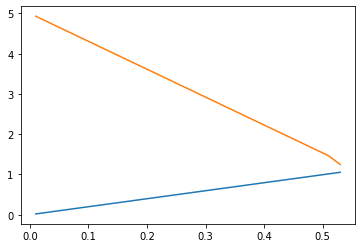

In [23]:
caso=frozenset({'SARO_RS09275', 'SARO_RS05890', 'SARO_RS04510', 'SARO_RS16100'})
xs=[]
y1s=[]
y2s=[]

bio=0.01
while bio <max_bio:
    with model3:
        for g in caso:
            model3.genes.get_by_id(g).knock_out()
        model3.reactions[biomass].bounds=[bio,bio]
        model3.objective=model3.reactions[objetivo]
        model3.objective_direction="min"
        sol1=model3.slim_optimize()
        model3.objective_direction="max"
        sol2=model3.slim_optimize()
        xs.append(bio)
        y1s.append(sol1)
        y2s.append(sol2)
        bio+=0.02
        
plt.plot(xs,y1s)
plt.plot(xs,y2s)

### NO SALEN:

* urea

In [21]:
bioproduct='C00086'
model3=cobra.io.read_sbml_model("./iNovo_engineered_2022.xml")

name='Export_'+bioproduct

reaction = Reaction(name)
reaction.compartment = 'e'
reaction.lower_bound = 0.  
reaction.upper_bound = 1000.  
reaction.add_metabolites({
    model3.metabolites.get_by_id(bioproduct): -1.0,
})
model3.add_reactions([reaction])

proportional_flux = model3.problem.Constraint(
    2*model3.reactions.get_by_id("EX_"+lista[singirico]).flux_expression - 3*model3.reactions.get_by_id("EX_"+lista[glucosa]).flux_expression,
    lb=0,
    ub=0)
model3.add_cons_vars(proportional_flux)

for i in range(2,len(lista)):
    r=model3.reactions.get_by_id("EX_"+lista[i])
    r.knock_out()
r=model3.reactions.get_by_id("EX_"+lista[glucosa])
r.lower_bound=-2
r=model3.reactions.get_by_id("EX_"+lista[vanilico])
r.lower_bound=-1000

for j in range(len(model3.reactions)):
    r=model3.reactions[j]
    if r.id=="biomass":
        biomass=j
    if r.id==name:
        objetivo=j

model3.objective=model3.reactions[biomass]
model3.objective_direction="max"
max_bio=model3.slim_optimize()

misReacciones, misValores = [biomass,objetivo],[[0.01,1000],[0,0]]

tope=4
asociados,reacciones=asociar(model3,tope)
sopG=dict()
misSoportes=creaSoportes(model3,tope,misReacciones,misValores)
for sop in misSoportes:
    sopG[sop]=soporteG(sop,tope,model3)
    
tiempos=[]
powers=dict()
CS1=CSV2(model3,tope,misReacciones,misValores,True,set())
print()
print('Estrategias para '+ model3.metabolites.get_by_id(bioproduct).name+ ':')

for i in range(len(CS1)):
    for caso in CS1[i]:
        with model3:
            for g in caso:
                model3.genes.get_by_id(g).knock_out()
            
            model3.objective=model3.reactions[biomass]
            model3.objective_direction="max"
            sol1=model3.slim_optimize(error_value=-1)
            print(sol1)
            if sol1>0:
                model3.objective=model3.reactions[objetivo]
                model3.objective_direction="min"
                model3.reactions[biomass].bounds=[0.01,1000]
                sol2=model3.slim_optimize(error_value=-1)
                model3.objective_direction="max"
                model3.reactions[biomass].bounds=[0.01,1000]
                sol3=model3.slim_optimize(error_value=-1)
                print(sol1,sol2,sol3)
                if sol2>0:
                    model3.reactions[biomass].lower_bound=sol1
                    model3.objective=model3.reactions[objetivo]
                    model3.objective_direction="min"
                    sol3=model3.slim_optimize()
                    print()
                    print('- '+ str(caso))
                    print()
                    print('     Max biomass: ',sol1)
                    print('     Min bioproduct: ',sol2)
                    print('     Min bioproduct with max growth: ',sol3)
                    print()


181
Final Fase 1 con 7 candidatos y 174 cutsets

Inicio de Fase 2 con 11 soportes
Mal 8
Mal 8
Mal 7
Mal 6
Mal 5
Mal 4
Mal 3
Mal 2
Mal 1
Mal 0
Mal 0
Parte paralela
Total 1507
0 Finales 0 1507
109
0 109 109
1 6 6 103
6 109 103
2 12 6 97
12 109 97
3 18 6 91
18 109 91
4 24 6 85
24 109 85
5 30 6 79
30 109 79
6 36 6 73
36 109 73
7 42 6 67
42 109 67
8 48 6 61
48 109 61
9 54 6 55
54 109 55
10 60 6 49
60 109 49
11 66 6 43
66 109 43
12 72 6 37
72 109 37
13 78 6 31
78 109 31
14 84 6 25
84 109 25
15 90 6 19
90 109 19
16 96 6 8
96 109 8
17 103 6 2
103 109 2
18 109 2 0

Lista2 96

Sin salto
96 96 0
1 95 1
96 95 1
2 94 2
96 94 2
3 93 3
96 93 3
4 73 3
96 73 3
5 72 4
96 72 4
6 71 5
96 71 5
7 70 6
96 70 6
8 69 7
96 69 7
9 66 7
96 66 7
10 61 7
96 61 7
11 60 8
96 60 8
96 60 8
96 60 8
14 56 8
96 56 8
15 55 8
96 55 8
16 48 8
96 48 8
17 47 9
96 47 9
96 47 9
19 46 9
96 46 9
96 46 9
96 46 9
96 46 9
96 46 9
24 45 10
96 45 10
96 45 10
26 44 10
96 44 10
27 43 10
96 43 10
96 43 10
96 43 10
30 41 10
96 41 10
96 41 

193 26 21
298 26 21
298 26 21
298 26 21
196 24 21
298 24 21
298 24 21
198 23 21
298 23 21
199 22 21
298 22 21
298 22 21
298 22 21
298 22 21
203 21 22
298 21 22
298 21 22
205 20 23
298 20 23
298 20 23
207 19 24
298 19 24
298 19 24
209 18 24
298 18 24
298 18 24
298 18 24
298 18 24
213 17 25
298 17 25
298 17 25
298 17 25
298 17 25
217 16 26
298 16 26
298 16 26
219 15 27
298 15 27
298 15 27
298 15 27
298 15 27
298 15 27
298 15 27
225 14 27
298 14 27
298 14 27
227 13 27
298 13 27
298 13 27
298 13 27
298 13 27
298 13 27
232 12 27
298 12 27
298 12 27
234 11 27
298 11 27
298 11 27
298 11 27
298 11 27
298 11 27
298 11 27
298 11 27
298 11 27
242 10 27
298 10 27
298 10 27
244 9 27
298 9 27
298 9 27
298 9 27
298 9 27
248 8 27
298 8 27
249 7 27
298 7 27
298 7 27
251 6 27
298 6 27
298 6 27
298 6 27
298 6 27
298 6 27
298 6 27
257 5 27
298 5 27
298 5 27
259 4 28
298 4 28
298 4 28
298 4 28
298 4 28
298 4 28
298 4 28
298 4 28
298 4 28
298 4 28
268 3 29
298 3 29
298 3 29
270 2 30
298 2 30
298 2 30
298 2 

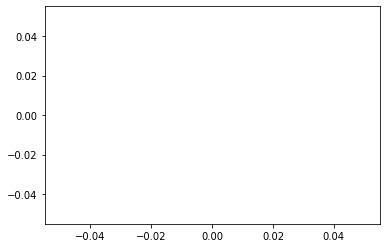

In [25]:
caso=frozenset({'SARO_RS09275', 'SARO_RS05890', 'SARO_RS04510', 'SARO_RS16100'})
xs=[]
y1s=[]
y2s=[]

bio=0.01
while bio <max_bio:
    with model3:
        for g in caso:
            model3.genes.get_by_id(g).knock_out()
        model3.reactions[biomass].bounds=[bio,bio]
        model3.objective=model3.reactions[objetivo]
        model3.objective_direction="min"
        sol1=model3.slim_optimize()
        model3.objective_direction="max"
        sol2=model3.slim_optimize()
        xs.append(bio)
        y1s.append(sol1)
        y2s.append(sol2)
        bio+=0.02
        
plt.plot(xs,y1s)
plt.plot(xs,y2s)

* acetato

In [26]:
bioproduct='C00033'
model3=cobra.io.read_sbml_model("./iNovo_engineered_2022.xml")

name='Export_'+bioproduct

reaction = Reaction(name)
reaction.compartment = 'e'
reaction.lower_bound = 0.  
reaction.upper_bound = 1000.  
reaction.add_metabolites({
    model3.metabolites.get_by_id(bioproduct): -1.0,
})
model3.add_reactions([reaction])

for i in range(2,len(lista)):
    r=model3.reactions.get_by_id("EX_"+lista[i])
    r.knock_out()
r=model3.reactions.get_by_id("EX_"+lista[glucosa])
r.lower_bound=0
r=model3.reactions.get_by_id("EX_"+lista[vanilico])
r.lower_bound=-5

for j in range(len(model3.reactions)):
    r=model3.reactions[j]
    if r.id=="biomass":
        biomass=j
    if r.id==name:
        objetivo=j

model3.objective=model3.reactions[biomass]
model3.objective_direction="max"
max_bio=model3.slim_optimize()

misReacciones, misValores = [biomass,objetivo],[[0.1,1000],[0,0]]

tope=4
asociados,reacciones=asociar(model3,tope)
sopG=dict()
misSoportes=creaSoportes(model3,tope,misReacciones,misValores)
for sop in misSoportes:
    sopG[sop]=soporteG(sop,tope,model3)
    
tiempos=[]
powers=dict()
CS1=CSV2(model3,tope,misReacciones,misValores,False,set())
print()
print('Estrategias para '+ model3.metabolites.get_by_id(bioproduct).name+ ':')

for i in range(len(CS1)):
    for caso in CS1[i]:
        with model3:
            for g in caso:
                model3.genes.get_by_id(g).knock_out()
            
            model3.objective=model3.reactions[biomass]
            model3.objective_direction="max"
            sol1=model3.slim_optimize(error_value=-1)
            if sol1>0:
                model3.objective=model3.reactions[objetivo]
                model3.objective_direction="min"
                model3.reactions[biomass].bounds=[0.1,1000]
                sol2=model3.slim_optimize(error_value=-1)
                if sol2>0:
                    model3.reactions[biomass].lower_bound=sol1
                    model3.objective=model3.reactions[objetivo]
                    model3.objective_direction="min"
                    sol3=model3.slim_optimize()
                    print()
                    print('- '+ str(caso))
                    print()
                    print('     Max biomass: ',sol1)
                    print('     Min bioproduct: ',sol2)
                    print('     Min bioproduct with max growth: ',sol3)
                    print()


Final Fase 1 con 8 candidatos y 174 cutsets

Inicio de Fase 2 con 10 soportes
Inicio de Fase 3 con 32 soportes
Inicio de Fase 4 con 78 soportes

Estrategias para acetate:


* etanolamina

In [ ]:
%%time

bioproduct='C00189'
model3=cobra.io.read_sbml_model("./iNovo_engineered_2022.xml")

name='Export_'+bioproduct

reaction = Reaction(name)
reaction.compartment = 'e'
reaction.lower_bound = 0.  
reaction.upper_bound = 1000.  
reaction.add_metabolites({
    model3.metabolites.get_by_id(bioproduct): -1.0,
})
model3.add_reactions([reaction])

for i in range(2,len(lista)):
    r=model3.reactions.get_by_id("EX_"+lista[i])
    r.knock_out()
r=model3.reactions.get_by_id("EX_"+lista[glucosa])
r.lower_bound=0
r=model3.reactions.get_by_id("EX_"+lista[vanilico])
r.lower_bound=-5

for j in range(len(model3.reactions)):
    r=model3.reactions[j]
    if r.id=="biomass":
        biomass=j
    if r.id==name:
        objetivo=j

model3.objective=model3.reactions[biomass]
model3.objective_direction="max"
max_bio=model3.slim_optimize()

misReacciones, misValores = [biomass,objetivo],[[0.1,1000],[0,0]]

tope=8
asociados,reacciones=asociar(model3,tope)
sopG=dict()
misSoportes=creaSoportes(model3,tope,misReacciones,misValores)
for sop in misSoportes:
    sopG[sop]=soporteG(sop,tope,model3)
    
tiempos=[]
powers=dict()
CS1=CSV2(model3,tope,misReacciones,misValores,True,set())
print()
print('Estrategias para '+ model3.metabolites.get_by_id(bioproduct).name+ ':')

for i in range(len(CS1)):
    for caso in CS1[i]:
        with model3:
            for g in caso:
                model3.genes.get_by_id(g).knock_out()
            
            model3.objective=model3.reactions[biomass]
            model3.objective_direction="max"
            sol1=model3.slim_optimize(error_value=-1)
            if sol1>0:
                model3.objective=model3.reactions[objetivo]
                model3.objective_direction="min"
                model3.reactions[biomass].bounds=[0.1,1000]
                sol2=model3.slim_optimize(error_value=-1)
                if sol2>0:
                    model3.reactions[biomass].lower_bound=sol1
                    model3.objective=model3.reactions[objetivo]
                    model3.objective_direction="min"
                    sol3=model3.slim_optimize()
                    print()
                    print('- '+ str(caso))
                    print()
                    print('     Max biomass: ',sol1)
                    print('     Min bioproduct: ',sol2)
                    print('     Min bioproduct with max growth: ',sol3)
                    print()


181
Final Fase 1 con 7 candidatos y 174 cutsets

Inicio de Fase 2 con 12 soportes
Mal 11
Mal 5
Mal 3
Mal 3
Mal 3
Mal 3
Mal 3
Mal 2
Mal 2
Mal 1
Mal 0
Mal 0
Parte paralela
Total 2035
0 Finales 0 2035
87
0 87 87
1 6 6 81
6 87 81
2 12 6 75
12 87 75
3 18 6 69
18 87 69
4 24 6 63
24 87 63
5 30 6 57
30 87 57
6 36 6 51
36 87 51
7 42 6 45
42 87 45
8 48 6 39
48 87 39
9 54 6 33
54 87 33
10 60 6 27
60 87 27
11 66 6 21
66 87 21
12 72 6 15
72 87 15
13 78 6 9
78 87 9
14 84 6 3
84 87 3
15 87 3 0

Lista2 87

Sin salto
87 87 0
1 74 0
87 74 0
2 73 1
87 73 1
87 73 1
4 69 1
87 69 1
87 69 1
6 68 2
87 68 2
87 68 2
8 63 2
87 63 2
9 58 2
87 58 2
10 57 3
87 57 3
11 56 3
87 56 3
12 55 4
87 55 4
13 54 5
87 54 5
14 53 5
87 53 5
15 51 5
87 51 5
16 50 6
87 50 6
17 49 7
87 49 7
18 48 7
87 48 7
19 47 8
87 47 8
20 44 8
87 44 8
21 41 8
87 41 8
22 40 9
87 40 9
23 39 10
87 39 10
87 39 10
25 38 11
87 38 11
87 38 11
87 38 11
28 37 12
87 37 12
87 37 12
87 37 12
87 37 12
32 36 13
87 36 13
33 35 14
87 35 14
34 34 14
87 34 14
35

248 33 13
438 33 13
438 33 13
438 33 13
251 32 13
438 32 13
438 32 13
253 31 13
438 31 13
438 31 13
255 30 14
438 30 14
438 30 14
257 29 14
438 29 14
438 29 14
438 29 14
438 29 14
438 29 14
438 29 14
438 29 14
438 29 14
265 28 15
438 28 15
266 27 16
438 27 16
438 27 16
438 27 16
269 26 17
438 26 17
438 26 17
438 26 17
438 26 17
438 26 17
274 25 18
438 25 18
438 25 18
438 25 18
277 24 19
438 24 19
438 24 19
438 24 19
438 24 19
438 24 19
438 24 19
438 24 19
438 24 19
438 24 19
286 23 19
438 23 19
438 23 19
438 23 19
438 23 19
438 23 19
438 23 19
438 23 19
438 23 19
438 23 19
438 23 19
438 23 19
438 23 19
438 23 19
438 23 19
438 23 19
438 23 19
438 23 19
438 23 19
438 23 19
438 23 19
438 23 19
438 23 19
308 22 20
438 22 20
309 21 20
438 21 20
438 21 20
438 21 20
438 21 20
438 21 20
438 21 20
438 21 20
316 20 20
438 20 20
438 20 20
438 20 20
438 20 20
438 20 20
438 20 20
438 20 20
438 20 20
324 19 21
438 19 21
438 19 21
438 19 21
438 19 21
328 18 22
438 18 22
438 18 22
438 18 22
438 18 22


186 1116 6 582
1116 1698 582
187 1122 6 576
1122 1698 576
188 1128 6 570
1128 1698 570
189 1134 6 564
1134 1698 564
190 1140 6 558
1140 1698 558
191 1146 6 552
1146 1698 552
192 1152 6 546
1152 1698 546
193 1158 6 540
1158 1698 540
194 1164 6 534
1164 1698 534
195 1170 6 528
1170 1698 528
196 1176 6 522
1176 1698 522
197 1182 6 516
1182 1698 516
198 1188 6 510
1188 1698 510
199 1194 6 504
1194 1698 504
200 1200 6 498
1200 1698 498
201 1206 6 492
1206 1698 492
202 1212 6 486
1212 1698 486
203 1218 6 480
1218 1698 480
204 1224 6 474
1224 1698 474
205 1230 6 468
1230 1698 468
206 1236 6 462
1236 1698 462
207 1242 6 456
1242 1698 456
208 1248 6 450
1248 1698 450
209 1254 6 444
1254 1698 444
210 1260 6 438
1260 1698 438
211 1266 6 432
1266 1698 432
212 1272 6 426
1272 1698 426
213 1278 6 420
1278 1698 420
214 1284 6 414
1284 1698 414
215 1290 6 408
1290 1698 408
216 1296 6 402
1296 1698 402
217 1302 6 396
1302 1698 396
218 1308 6 390
1308 1698 390
219 1314 6 384
1314 1698 384
220 1320 6 378

420 140 2
1698 140 2
1698 140 2
1698 140 2
1698 140 2
1698 140 2
1698 140 2
1698 140 2
427 139 2
1698 139 2
1698 139 2
1698 139 2
1698 139 2
1698 139 2
432 132 2
1698 132 2
1698 132 2
1698 132 2
1698 132 2
1698 132 2
1698 132 2
1698 132 2
1698 132 2
1698 132 2
1698 132 2
1698 132 2
1698 132 2
1698 132 2
1698 132 2
1698 132 2
447 129 2
1698 129 2
448 126 2
1698 126 2
1698 126 2
1698 126 2
1698 126 2
452 122 2
1698 122 2
1698 122 2
1698 122 2
455 121 2
1698 121 2
1698 121 2
1698 121 2
1698 121 2
1698 121 2
1698 121 2
1698 121 2
462 115 2
1698 115 2
1698 115 2
1698 115 2
1698 115 2
1698 115 2
1698 115 2
1698 115 2
1698 115 2
1698 115 2
1698 115 2
1698 115 2
1698 115 2
1698 115 2
475 112 2
1698 112 2
1698 112 2
1698 112 2
478 110 2
1698 110 2
1698 110 2
1698 110 2
1698 110 2
1698 110 2
1698 110 2
1698 110 2
1698 110 2
1698 110 2
1698 110 2
1698 110 2
1698 110 2
1698 110 2
1698 110 2
1698 110 2
1698 110 2
1698 110 2
1698 110 2
1698 110 2
1698 110 2
1698 110 2
499 107 2
1698 107 2
1698 107 2

1469 9 5
1698 9 5
1698 9 5
1698 9 5
1698 9 5
1698 9 5
1698 9 5
1698 9 5
1698 9 5
1698 9 5
1698 9 5
1698 9 5
1698 9 5
1698 9 5
1698 9 5
1698 9 5
1698 9 5
1698 9 5
1698 9 5
1698 9 5
1488 8 5
1698 8 5
1698 8 5
1698 8 5
1698 8 5
1698 8 5
1698 8 5
1698 8 5
1698 8 5
1698 8 5
1698 8 5
1698 8 5
1698 8 5
1698 8 5
1698 8 5
1698 8 5
1698 8 5
1698 8 5
1698 8 5
1698 8 5
1698 8 5
1698 8 5
1698 8 5
1698 8 5
1698 8 5
1698 8 5
1698 8 5
1698 8 5
1698 8 5
1698 8 5
1698 8 5
1698 8 5
1698 8 5
1698 8 5
1698 8 5
1698 8 5
1698 8 5
1698 8 5
1698 8 5
1698 8 5
1698 8 5
1698 8 5
1698 8 5
1530 7 6
1698 7 6
1698 7 6
1698 7 6
1698 7 6
1698 7 6
1698 7 6
1698 7 6
1698 7 6
1698 7 6
1698 7 6
1698 7 6
1698 7 6
1698 7 6
1698 7 6
1698 7 6
1698 7 6
1698 7 6
1698 7 6
1698 7 6
1549 6 6
1698 6 6
1698 6 6
1698 6 6
1698 6 6
1698 6 6
1698 6 6
1698 6 6
1698 6 6
1698 6 6
1698 6 6
1698 6 6
1698 6 6
1698 6 6
1698 6 6
1698 6 6
1698 6 6
1698 6 6
1698 6 6
1698 6 6
1698 6 6
1698 6 6
1698 6 6
1698 6 6
1572 5 6
1698 5 6
1698 5 6
1698 5 6
1

143 858 6 2327
858 3185 2327
144 864 6 2321
864 3185 2321
145 870 6 2315
870 3185 2315
146 876 6 2309
876 3185 2309
147 882 6 2303
882 3185 2303
148 888 6 2297
888 3185 2297
149 894 6 2291
894 3185 2291
150 900 6 2285
900 3185 2285
151 906 6 2279
906 3185 2279
152 912 6 2273
912 3185 2273
153 918 6 2267
918 3185 2267
154 924 6 2261
924 3185 2261
155 930 6 2255
930 3185 2255
156 936 6 2249
936 3185 2249
157 942 6 2243
942 3185 2243
158 948 6 2237
948 3185 2237
159 954 6 2231
954 3185 2231
160 960 6 2225
960 3185 2225
161 966 6 2219
966 3185 2219
162 972 6 2213
972 3185 2213
163 978 6 2207
978 3185 2207
164 984 6 2201
984 3185 2201
165 990 6 2195
990 3185 2195
166 996 6 2189
996 3185 2189
167 1002 6 2183
1002 3185 2183
168 1008 6 2177
1008 3185 2177
169 1014 6 2171
1014 3185 2171
170 1020 6 2165
1020 3185 2165
171 1026 6 2159
1026 3185 2159
172 1032 6 2153
1032 3185 2153
173 1038 6 2147
1038 3185 2147
174 1044 6 2141
1044 3185 2141
175 1050 6 2135
1050 3185 2135
176 1056 6 2129
1056 3185

420 2560 6 529
2560 3185 529
421 2568 6 523
2568 3185 523
422 2575 6 517
2575 3185 517
423 2582 6 511
2582 3185 511
424 2589 6 505
2589 3185 505
425 2597 6 499
2597 3185 499
426 2603 6 493
2603 3185 493
427 2610 6 487
2610 3185 487
428 2616 6 481
2616 3185 481
429 2622 6 475
2622 3185 475
430 2628 6 469
2628 3185 469
431 2635 6 463
2635 3185 463
432 2641 6 457
2641 3185 457
433 2647 6 451
2647 3185 451
434 2653 6 445
2653 3185 445
435 2660 6 439
2660 3185 439
436 2667 6 433
2667 3185 433
437 2674 6 427
2674 3185 427
438 2681 6 421
2681 3185 421
439 2687 6 415
2687 3185 415
440 2695 6 409
2695 3185 409
441 2701 6 403
2701 3185 403
442 2709 6 397
2709 3185 397
443 2715 6 391
2715 3185 391
444 2722 6 385
2722 3185 385
445 2728 6 379
2728 3185 379
446 2735 6 373
2735 3185 373
447 2742 6 367
2742 3185 367
448 2750 6 361
2750 3185 361
449 2758 6 355
2758 3185 355
450 2768 6 349
2768 3185 349
451 2774 6 343
2774 3185 343
452 2782 6 337
2782 3185 337
453 2789 6 331
2789 3185 331
454 2795 6 325

395 477 5
3042 477 5
396 473 5
3042 473 5
3042 473 5
3042 473 5
3042 473 5
400 468 5
3042 468 5
3042 468 5
3042 468 5
3042 468 5
3042 468 5
3042 468 5
3042 468 5
3042 468 5
3042 468 5
409 452 5
3042 452 5
3042 452 5
3042 452 5
3042 452 5
3042 452 5
3042 452 5
415 440 5
3042 440 5
3042 440 5
3042 440 5
3042 440 5
3042 440 5
3042 440 5
3042 440 5
3042 440 5
3042 440 5
3042 440 5
425 436 5
3042 436 5
3042 436 5
3042 436 5
3042 436 5
3042 436 5
3042 436 5
3042 436 5
3042 436 5
3042 436 5
3042 436 5
3042 436 5
3042 436 5
3042 436 5
3042 436 5
439 433 5
3042 433 5
3042 433 5
3042 433 5
3042 433 5
3042 433 5
3042 433 5
445 425 5
3042 425 5
3042 425 5
3042 425 5
448 418 5
3042 418 5
3042 418 5
3042 418 5
451 414 5
3042 414 5
3042 414 5
3042 414 5
454 411 5
3042 411 5
3042 411 5
3042 411 5
3042 411 5
3042 411 5
3042 411 5
3042 411 5
3042 411 5
3042 411 5
3042 411 5
3042 411 5
3042 411 5
3042 411 5
3042 411 5
3042 411 5
469 405 5
3042 405 5
3042 405 5
3042 405 5
3042 405 5
3042 405 5
3042 405 5


1048 189 12
3042 189 12
3042 189 12
3042 189 12
3042 189 12
3042 189 12
3042 189 12
3042 189 12
3042 189 12
3042 189 12
3042 189 12
3042 189 12
3042 189 12
3042 189 12
3042 189 12
3042 189 12
3042 189 12
3042 189 12
3042 189 12
3042 189 12
3042 189 12
1068 186 12
3042 186 12
3042 186 12
3042 186 12
3042 186 12
3042 186 12
1073 185 13
3042 185 13
3042 185 13
3042 185 13
3042 185 13
3042 185 13
3042 185 13
3042 185 13
3042 185 13
3042 185 13
3042 185 13
3042 185 13
3042 185 13
3042 185 13
3042 185 13
3042 185 13
3042 185 13
3042 185 13
3042 185 13
3042 185 13
3042 185 13
3042 185 13
3042 185 13
3042 185 13
3042 185 13
3042 185 13
3042 185 13
3042 185 13
3042 185 13
1101 182 13
3042 182 13
3042 182 13
3042 182 13
1104 179 13
3042 179 13
3042 179 13
3042 179 13
3042 179 13
3042 179 13
3042 179 13
3042 179 13
3042 179 13
3042 179 13
3042 179 13
3042 179 13
3042 179 13
3042 179 13
3042 179 13
3042 179 13
3042 179 13
3042 179 13
3042 179 13
3042 179 13
1123 177 13
3042 177 13
3042 177 13
3042

1756 92 21
3042 92 21
3042 92 21
3042 92 21
3042 92 21
3042 92 21
3042 92 21
3042 92 21
3042 92 21
3042 92 21
3042 92 21
3042 92 21
3042 92 21
3042 92 21
3042 92 21
3042 92 21
3042 92 21
3042 92 21
3042 92 21
3042 92 21
3042 92 21
3042 92 21
3042 92 21
3042 92 21
3042 92 21
3042 92 21
3042 92 21
1782 89 21
3042 89 21
3042 89 21
3042 89 21
3042 89 21
3042 89 21
3042 89 21
3042 89 21
3042 89 21
3042 89 21
3042 89 21
3042 89 21
1793 86 21
3042 86 21
3042 86 21
3042 86 21
3042 86 21
3042 86 21
3042 86 21
1799 83 21
3042 83 21
3042 83 21
3042 83 21
3042 83 21
3042 83 21
3042 83 21
3042 83 21
3042 83 21
3042 83 21
3042 83 21
3042 83 21
3042 83 21
3042 83 21
3042 83 21
3042 83 21
3042 83 21
3042 83 21
3042 83 21
3042 83 21
3042 83 21
3042 83 21
3042 83 21
3042 83 21
3042 83 21
3042 83 21
3042 83 21
3042 83 21
3042 83 21
3042 83 21
3042 83 21
3042 83 21
3042 83 21
3042 83 21
3042 83 21
3042 83 21
3042 83 21
3042 83 21
3042 83 21
3042 83 21
3042 83 21
3042 83 21
3042 83 21
3042 83 21
3042 83 21

2502 31 31
3042 31 31
3042 31 31
3042 31 31
3042 31 31
3042 31 31
2507 29 31
3042 29 31
3042 29 31
3042 29 31
3042 29 31
3042 29 31
3042 29 31
3042 29 31
3042 29 31
3042 29 31
3042 29 31
3042 29 31
3042 29 31
2519 28 31
3042 28 31
3042 28 31
3042 28 31
3042 28 31
3042 28 31
3042 28 31
2525 26 31
3042 26 31
3042 26 31
3042 26 31
3042 26 31
3042 26 31
3042 26 31
3042 26 31
3042 26 31
3042 26 31
3042 26 31
3042 26 31
3042 26 31
3042 26 31
3042 26 31
3042 26 31
3042 26 31
3042 26 31
3042 26 31
3042 26 31
3042 26 31
3042 26 31
3042 26 31
3042 26 31
3042 26 31
3042 26 31
3042 26 31
3042 26 31
3042 26 31
3042 26 31
3042 26 31
3042 26 31
3042 26 31
3042 26 31
2558 25 31
3042 25 31
3042 25 31
3042 25 31
3042 25 31
3042 25 31
3042 25 31
3042 25 31
3042 25 31
3042 25 31
3042 25 31
3042 25 31
2569 24 32
3042 24 32
3042 24 32
3042 24 32
2572 23 33
3042 23 33
3042 23 33
3042 23 33
3042 23 33
3042 23 33
3042 23 33
3042 23 33
3042 23 33
3042 23 33
3042 23 33
3042 23 33
3042 23 33
3042 23 33
3042 23 33

Mal 1544
Mal 1544
Mal 1544
Mal 1542
Mal 1541
Mal 1525
Mal 1521
Mal 1489
Mal 1489
Mal 1477
Mal 1442
Mal 1442
Mal 1442
Mal 1438
Mal 1438
Mal 1437
Mal 1422
Mal 1416
Mal 1412
Mal 1412
Mal 1408
Mal 1408
Mal 1403
Mal 1388
Mal 1372
Mal 1381
Mal 1381
Mal 1381
Mal 1379
Mal 1373
Mal 1360
Mal 1360
Mal 1338
Mal 1338
Mal 1338
Mal 1338
Mal 1302
Mal 1300
Mal 1300
Mal 1281
Mal 1272
Mal 1272
Mal 1269
Mal 1269
Mal 1269
Mal 1269
Mal 1209
Mal 1193
Mal 1189
Mal 1189
Mal 1161
Mal 1157
Mal 1136
Mal 1117
Mal 1120
Mal 1056
Mal 1056
Mal 1050
Mal 1050
Mal 1047
Mal 1047
Mal 1040
Mal 1026
Mal 1020
Mal 1010
Mal 950
Mal 946
Mal 941
Mal 941
Mal 940
Mal 939
Mal 939
Mal 934
Mal 934
Mal 934
Mal 934
Mal 916
Mal 916
Mal 916
Mal 916
Mal 888
Mal 878
Mal 878
Mal 878
Mal 840
Mal 840
Mal 792
Mal 786
Mal 783
Mal 777
Mal 776
Mal 757
Mal 757
Mal 746
Mal 746
Mal 725
Mal 716
Mal 712
Mal 712
Mal 712
Mal 709
Mal 709
Mal 706
Mal 706
Mal 706
Mal 705
Mal 703
Mal 684
Mal 684
Mal 684
Mal 683
Mal 683
Mal 683
Mal 683
Mal 679
Mal 676
Mal 666

185 1110 6 2666
1110 3776 2666
186 1116 6 2660
1116 3776 2660
187 1122 6 2654
1122 3776 2654
188 1128 6 2648
1128 3776 2648
189 1134 6 2642
1134 3776 2642
190 1140 6 2636
1140 3776 2636
191 1146 6 2630
1146 3776 2630
192 1152 6 2624
1152 3776 2624
193 1158 6 2618
1158 3776 2618
194 1164 6 2612
1164 3776 2612
195 1170 6 2606
1170 3776 2606
196 1176 6 2600
1176 3776 2600
197 1182 6 2594
1182 3776 2594
198 1188 6 2588
1188 3776 2588
199 1194 6 2582
1194 3776 2582
200 1200 6 2576
1200 3776 2576
201 1206 6 2570
1206 3776 2570
202 1212 6 2564
1212 3776 2564
203 1218 6 2558
1218 3776 2558
204 1224 6 2552
1224 3776 2552
205 1230 6 2546
1230 3776 2546
206 1236 6 2540
1236 3776 2540
207 1242 6 2534
1242 3776 2534
208 1248 6 2528
1248 3776 2528
209 1254 6 2522
1254 3776 2522
210 1260 6 2516
1260 3776 2516
211 1266 6 2510
1266 3776 2510
212 1272 6 2504
1272 3776 2504
213 1278 6 2498
1278 3776 2498
214 1284 6 2492
1284 3776 2492
215 1290 6 2486
1290 3776 2486
216 1296 6 2480
1296 3776 2480
217 1302

457 2742 6 1034
2742 3776 1034
458 2748 6 1028
2748 3776 1028
459 2754 6 1022
2754 3776 1022
460 2760 6 1016
2760 3776 1016
461 2766 6 1010
2766 3776 1010
462 2772 6 1004
2772 3776 1004
463 2778 6 998
2778 3776 998
464 2784 6 992
2784 3776 992
465 2790 6 986
2790 3776 986
466 2796 6 980
2796 3776 980
467 2802 6 974
2802 3776 974
468 2808 6 968
2808 3776 968
469 2814 6 962
2814 3776 962
470 2820 6 956
2820 3776 956
471 2826 6 950
2826 3776 950
472 2832 6 944
2832 3776 944
473 2838 6 938
2838 3776 938
474 2844 6 932
2844 3776 932
475 2850 6 926
2850 3776 926
476 2856 6 920
2856 3776 920
477 2862 6 914
2862 3776 914
478 2868 6 908
2868 3776 908
479 2874 6 902
2874 3776 902
480 2880 6 896
2880 3776 896
481 2886 6 890
2886 3776 890
482 2892 6 884
2892 3776 884
483 2898 6 878
2898 3776 878
484 2904 6 872
2904 3776 872
485 2910 6 866
2910 3776 866
486 2916 6 860
2916 3776 860
487 2922 6 854
2922 3776 854
488 2928 6 848
2928 3776 848
489 2934 6 842
2934 3776 842
490 2940 6 836
2940 3776 836
49

178 1445 0
3774 1445 0
3774 1445 0
3774 1445 0
3774 1445 0
182 1444 1
3774 1444 1
183 1422 1
3774 1422 1
3774 1422 1
185 1421 1
3774 1421 1
3774 1421 1
187 1416 1
3774 1416 1
3774 1416 1
3774 1416 1
190 1409 1
3774 1409 1
191 1403 1
3774 1403 1
192 1400 1
3774 1400 1
193 1382 1
3774 1382 1
3774 1382 1
3774 1382 1
196 1370 1
3774 1370 1
3774 1370 1
3774 1370 1
3774 1370 1
200 1360 1
3774 1360 1
201 1354 1
3774 1354 1
202 1350 1
3774 1350 1
3774 1350 1
3774 1350 1
3774 1350 1
3774 1350 1
207 1332 1
3774 1332 1
208 1326 1
3774 1326 1
209 1325 2
3774 1325 2
3774 1325 2
3774 1325 2
3774 1325 2
213 1323 2
3774 1323 2
3774 1323 2
3774 1323 2
3774 1323 2
3774 1323 2
3774 1323 2
219 1309 2
3774 1309 2
3774 1309 2
3774 1309 2
222 1304 2
3774 1304 2
223 1286 2
3774 1286 2
3774 1286 2
3774 1286 2
3774 1286 2
227 1285 3
3774 1285 3
3774 1285 3
3774 1285 3
230 1272 3
3774 1272 3
3774 1272 3
3774 1272 3
3774 1272 3
3774 1272 3
235 1264 3
3774 1264 3
3774 1264 3
3774 1264 3
238 1258 3
3774 1258 3
239 

789 482 4
3774 482 4
3774 482 4
3774 482 4
3774 482 4
3774 482 4
3774 482 4
3774 482 4
3774 482 4
3774 482 4
798 477 4
3774 477 4
3774 477 4
3774 477 4
3774 477 4
3774 477 4
3774 477 4
3774 477 4
3774 477 4
3774 477 4
3774 477 4
3774 477 4
3774 477 4
810 476 4
3774 476 4
3774 476 4
3774 476 4
3774 476 4
3774 476 4
3774 476 4
3774 476 4
3774 476 4
3774 476 4
3774 476 4
3774 476 4
3774 476 4
3774 476 4
3774 476 4
3774 476 4
3774 476 4
3774 476 4
3774 476 4
3774 476 4
829 458 4
3774 458 4
830 457 4
3774 457 4
3774 457 4
3774 457 4
3774 457 4
3774 457 4
3774 457 4
3774 457 4
3774 457 4
3774 457 4
3774 457 4
3774 457 4
3774 457 4
3774 457 4
3774 457 4
3774 457 4
3774 457 4
846 456 4
3774 456 4
3774 456 4
3774 456 4
3774 456 4
3774 456 4
3774 456 4
3774 456 4
3774 456 4
3774 456 4
3774 456 4
3774 456 4
857 454 4
3774 454 4
3774 454 4
859 452 4
3774 452 4
860 449 4
3774 449 4
3774 449 4
3774 449 4
3774 449 4
3774 449 4
3774 449 4
3774 449 4
3774 449 4
3774 449 4
869 448 4
3774 448 4
3774 448 

1495 210 9
3774 210 9
3774 210 9
3774 210 9
1498 209 9
3774 209 9
3774 209 9
3774 209 9
3774 209 9
3774 209 9
3774 209 9
3774 209 9
3774 209 9
3774 209 9
1507 208 9
3774 208 9
3774 208 9
3774 208 9
3774 208 9
3774 208 9
3774 208 9
3774 208 9
3774 208 9
3774 208 9
3774 208 9
3774 208 9
1518 206 9
3774 206 9
3774 206 9
3774 206 9
3774 206 9
3774 206 9
3774 206 9
3774 206 9
3774 206 9
3774 206 9
3774 206 9
1528 200 9
3774 200 9
3774 200 9
1530 199 9
3774 199 9
3774 199 9
3774 199 9
3774 199 9
1534 198 9
3774 198 9
3774 198 9
3774 198 9
3774 198 9
3774 198 9
3774 198 9
3774 198 9
3774 198 9
3774 198 9
3774 198 9
1544 197 9
3774 197 9
3774 197 9
3774 197 9
3774 197 9
3774 197 9
3774 197 9
3774 197 9
1551 195 9
3774 195 9
1552 194 9
3774 194 9
3774 194 9
3774 194 9
3774 194 9
3774 194 9
3774 194 9
3774 194 9
3774 194 9
3774 194 9
3774 194 9
3774 194 9
3774 194 9
3774 194 9
3774 194 9
3774 194 9
3774 194 9
3774 194 9
3774 194 9
3774 194 9
3774 194 9
3774 194 9
3774 194 9
3774 194 9
3774 194 9

2313 96 15
3774 96 15
3774 96 15
2315 95 15
3774 95 15
3774 95 15
3774 95 15
3774 95 15
3774 95 15
3774 95 15
3774 95 15
2322 93 15
3774 93 15
3774 93 15
3774 93 15
3774 93 15
3774 93 15
3774 93 15
3774 93 15
3774 93 15
3774 93 15
3774 93 15
3774 93 15
3774 93 15
3774 93 15
3774 93 15
2336 92 15
3774 92 15
3774 92 15
3774 92 15
3774 92 15
3774 92 15
3774 92 15
3774 92 15
3774 92 15
3774 92 15
3774 92 15
3774 92 15
3774 92 15
3774 92 15
3774 92 15
3774 92 15
3774 92 15
3774 92 15
3774 92 15
3774 92 15
3774 92 15
3774 92 15
3774 92 15
3774 92 15
3774 92 15
3774 92 15
3774 92 15
3774 92 15
3774 92 15
3774 92 15
3774 92 15
3774 92 15
3774 92 15
3774 92 15
2369 90 15
3774 90 15
3774 90 15
3774 90 15
3774 90 15
3774 90 15
3774 90 15
3774 90 15
3774 90 15
3774 90 15
3774 90 15
3774 90 15
3774 90 15
3774 90 15
3774 90 15
2383 89 15
3774 89 15
3774 89 15
3774 89 15
3774 89 15
3774 89 15
3774 89 15
3774 89 15
3774 89 15
3774 89 15
3774 89 15
3774 89 15
3774 89 15
3774 89 15
2396 87 15
3774 87 15

3136 34 18
3774 34 18
3774 34 18
3774 34 18
3774 34 18
3774 34 18
3774 34 18
3774 34 18
3774 34 18
3774 34 18
3145 33 18
3774 33 18
3774 33 18
3774 33 18
3774 33 18
3774 33 18
3774 33 18
3774 33 18
3774 33 18
3774 33 18
3774 33 18
3774 33 18
3774 33 18
3774 33 18
3774 33 18
3774 33 18
3774 33 18
3774 33 18
3774 33 18
3774 33 18
3774 33 18
3774 33 18
3774 33 18
3774 33 18
3774 33 18
3774 33 18
3774 33 18
3774 33 18
3774 33 18
3774 33 18
3774 33 18
3774 33 18
3774 33 18
3774 33 18
3774 33 18
3774 33 18
3774 33 18
3774 33 18
3774 33 18
3774 33 18
3774 33 18
3774 33 18
3774 33 18
3774 33 18
3774 33 18
3774 33 18
3774 33 18
3774 33 18
3774 33 18
3774 33 18
3774 33 18
3774 33 18
3774 33 18
3774 33 18
3774 33 18
3774 33 18
3774 33 18
3774 33 18
3774 33 18
3774 33 18
3774 33 18
3774 33 18
3774 33 18
3774 33 18
3774 33 18
3774 33 18
3774 33 18
3774 33 18
3774 33 18
3774 33 18
3774 33 18
3215 31 18
3774 31 18
3774 31 18
3774 31 18
3774 31 18
3774 31 18
3774 31 18
3774 31 18
3774 31 18
3774 31 18

Mal 9654
Mal 9669
Mal 9661
Mal 9599
Mal 9599
Mal 9596
Mal 9599
Mal 9614
Mal 9598
Mal 9726
Mal 9657
Mal 9685
Mal 9692
Mal 9692
Mal 9692
Mal 9693
Mal 9682
Mal 9706
Mal 9706
Mal 9700
Mal 9688
Mal 9674
Mal 9756
Mal 9742
Mal 9722
Mal 9848
Mal 9839
Mal 9817
Mal 9818
Mal 9789
Mal 9780
Mal 9752
Mal 9752
Mal 9802
Mal 9802
Mal 9854
Mal 9852
Mal 9861
Mal 9844
Mal 9790
Mal 9870
Mal 9849
Mal 9849
Mal 9965
Mal 9918
Mal 9917
Mal 9893
Mal 9874
Mal 9696
Mal 9690
Mal 9719
Mal 9702
Mal 9674
Mal 9691
Mal 9644
Mal 9644
Mal 9620
Mal 9524
Mal 9518
Mal 9477
Mal 9437
Mal 9437
Mal 9437
Mal 9437
Mal 9457
Mal 9277
Mal 9251
Mal 9254
Mal 9240
Mal 9220
Mal 9190
Mal 9144
Mal 9118
Mal 9181
Mal 9175
Mal 9162
Mal 9162
Mal 9105
Mal 8989
Mal 8889
Mal 8915
Mal 8915
Mal 8833
Mal 8833
Mal 8813
Mal 8672
Mal 8682
Mal 8588
Mal 8571
Mal 8559
Mal 8526
Mal 8655
Mal 8631
Mal 8622
Mal 8604
Mal 8514
Mal 8497
Mal 8454
Mal 8420
Mal 8420
Mal 8452
Mal 8441
Mal 8429
Mal 8406
Mal 8394
Mal 8314
Mal 8314
Mal 8291
Mal 8289
Mal 8279
Mal 8258
M

In [39]:
for i in range(len(CS1)):
    print(i,len(CS1[i]))

0 0
1 174
2 38
3 13
4 30
5 7
6 42
7 23


In [40]:
for i in range(len(CS1)):
    for caso in CS1[i]:
        with model3:
            for g in caso:
                model3.genes.get_by_id(g).knock_out()
            
            model3.objective=model3.reactions[biomass]
            model3.objective_direction="max"
            sol1=model3.slim_optimize(error_value=-1)
            if sol1>0:
                model3.objective=model3.reactions[objetivo]
                model3.objective_direction="min"
                model3.reactions[biomass].bounds=[0.1,1000]
                sol2=model3.slim_optimize(error_value=-1)
                print(caso, sol1,sol2)

* ácido mucónico cis-cis

In [29]:
bioproduct='C02480'

model3=cobra.io.read_sbml_model("./iNovo_engineered_2022.xml")

name='Export_'+bioproduct

reaction = Reaction(name)
reaction.compartment = 'e'
reaction.lower_bound = 0.  # This is the default
reaction.upper_bound = 1000.  # This is the default
reaction.add_metabolites({
    model3.metabolites.get_by_id(bioproduct): -1.0,
})
model3.add_reactions([reaction])

for i in range(2,len(lista)):
    r=model3.reactions.get_by_id("EX_"+lista[i])
    r.knock_out()
r=model3.reactions.get_by_id("EX_"+lista[glucosa])
r.lower_bound=0
r=model3.reactions.get_by_id("EX_"+lista[vanilico])
r.lower_bound=-5

for j in range(len(model3.reactions)):
    r=model3.reactions[j]
    if r.id=="biomass":
        biomass=j
    if r.id==name:
        objetivo=j

model3.objective=model3.reactions[biomass]
model3.objective_direction="max"
max_bio=model3.slim_optimize()

misReacciones, misValores = [biomass,objetivo],[[0.1,1000],[0,0]]

tope=4
asociados,reacciones=asociar(model3,tope)
sopG=dict()
misSoportes=creaSoportes(model3,tope,misReacciones,misValores)
for sop in misSoportes:
    sopG[sop]=soporteG(sop,tope,model3)
    
tiempos=[]
powers=dict()
CS1=CSV2(model3,tope,misReacciones,misValores,False,set())
print()
print('Estrategias para '+ model3.metabolites.get_by_id(bioproduct).name+ ':')

for i in range(len(CS1)):
    for caso in CS1[i]:
        with model3:
            for g in caso:
                model3.genes.get_by_id(g).knock_out()
            
            model3.objective=model3.reactions[biomass]
            model3.objective_direction="max"
            sol1=model3.slim_optimize(error_value=-1)
            if sol1>0:
                model3.objective=model3.reactions[objetivo]
                model3.objective_direction="min"
                model3.reactions[biomass].bounds=[0.1,1000]
                sol2=model3.slim_optimize(error_value=-1)
                if sol2>0:
                    model3.reactions[biomass].lower_bound=sol1
                    model3.objective=model3.reactions[objetivo]
                    model3.objective_direction="min"
                    sol3=model3.slim_optimize()
                    print()
                    print('- '+ str(caso))
                    print()
                    print('     Max biomass: ',sol1)
                    print('     Min bioproduct: ',sol2)
                    print('     Min bioproduct with max growth: ',sol3)
                    print()


Final Fase 1 con 6 candidatos y 174 cutsets

Inicio de Fase 2 con 10 soportes
Inicio de Fase 3 con 27 soportes
Inicio de Fase 4 con 54 soportes

Estrategias para cis-cis muconic acid:


In [30]:
for i in range(len(CS1)):
    for caso in CS1[i]:
        with model3:
            for g in caso:
                model3.genes.get_by_id(g).knock_out()
            
            model3.objective=model3.reactions[biomass]
            model3.objective_direction="max"
            sol1=model3.slim_optimize(error_value=-1)
            model3.objective=model3.reactions[objetivo]
            model3.objective_direction="min"
            model3.reactions[biomass].bounds=[0.1,1000]
            sol2=model3.slim_optimize(error_value=-1)
            print(caso,sol1,sol2)

frozenset({'SARO_RS04550'}) 0.0 -1
frozenset({'SARO_RS14270'}) -1 -1
frozenset({'SARO_RS00095'}) 0.0 -1
frozenset({'SARO_RS09185'}) 0.0 -1
frozenset({'SARO_RS00105'}) 0.0 -1
frozenset({'SARO_RS11510'}) 0.0 -1
frozenset({'SARO_RS00520'}) 0.0 -1
frozenset({'SARO_RS00240'}) 0.0 -1
frozenset({'SARO_RS14135'}) 0.0 -1
frozenset({'SARO_RS05040'}) 0.0 -1
frozenset({'SARO_RS00020'}) 0.0 -1
frozenset({'SARO_RS04610'}) 0.0 -1
frozenset({'SARO_RS15545'}) 0.0 -1
frozenset({'SARO_RS08300'}) 0.0 -1
frozenset({'SARO_RS11150'}) 0.0 -1
frozenset({'SARO_RS07160'}) 0.0 -1
frozenset({'SARO_RS08770'}) 0.0 -1
frozenset({'SARO_RS00965'}) 0.0 -1
frozenset({'SARO_RS09870'}) 0.0 -1
frozenset({'SARO_RS03415'}) 0.0 -1
frozenset({'SARO_RS10175'}) 0.0 -1
frozenset({'SARO_RS02085'}) 0.0 -1
frozenset({'spontaneous'}) -1 -1
frozenset({'SARO_RS16780'}) 0.0 -1
frozenset({'SARO_RS02340'}) 0.0 -1
frozenset({'SARO_RS11405'}) 0.0 -1
frozenset({'SARO_RS17170'}) 0.0 -1
frozenset({'SARO_RS00530'}) 0.0 -1
frozenset({'SARO_RS0059

frozenset({'SARO_RS10375', 'SARO_RS12770', 'SARO_RS12950'}) 0.0 -1
frozenset({'SARO_RS00425', 'SARO_RS12290', 'SARO_RS14125'}) 0.0 -1
frozenset({'SARO_RS02740', 'SARO_RS13140', 'SARO_RS15075'}) 0.0 -1
frozenset({'SARO_RS06150', 'SARO_RS19050', 'SARO_RS10090'}) 0.0 -1
frozenset({'SARO_RS02820', 'SARO_RS08855', 'Saro_3563'}) 0.0 -1
frozenset({'SARO_RS06365', 'SARO_RS12870', 'SARO_RS01055'}) 0.0 -1
frozenset({'SARO_RS07390', 'SARO_RS07925', 'SARO_RS02600'}) 0.0 -1
frozenset({'SARO_RS11710', 'SARO_RS16455', 'SARO_RS02730'}) 0.0 -1
frozenset({'SARO_RS08405', 'SARO_RS17265', 'SARO_RS17285'}) 0.0 -1
frozenset({'SARO_RS11365', 'SARO_RS02790', 'SARO_RS09485', 'SARO_RS02165'}) -1 -1
frozenset({'SARO_RS06365', 'SARO_RS05490', 'SARO_RS01055', 'SARO_RS12875'}) 0.0 -1
frozenset({'SARO_RS02790', 'SARO_RS02165', 'SARO_RS09480', 'SARO_RS13605'}) -1 -1
frozenset({'SARO_RS11365', 'SARO_RS02790', 'SARO_RS02165', 'SARO_RS09490'}) -1 -1
frozenset({'SARO_RS09250', 'SARO_RS11365', 'SARO_RS09485', 'SARO_RS0216

* zeaxantina

In [31]:
bioproduct='C06098'
model3=cobra.io.read_sbml_model("./iNovo_engineered_2022.xml")

name='Export_'+bioproduct

reaction = Reaction(name)
reaction.compartment = 'e'
reaction.lower_bound = 0.  # This is the default
reaction.upper_bound = 1000.  # This is the default
reaction.add_metabolites({
    model3.metabolites.get_by_id(bioproduct): -1.0,
})
model3.add_reactions([reaction])

for i in range(2,len(lista)):
    r=model3.reactions.get_by_id("EX_"+lista[i])
    r.knock_out()
r=model3.reactions.get_by_id("EX_"+lista[glucosa])
r.lower_bound=0
r=model3.reactions.get_by_id("EX_"+lista[vanilico])
r.lower_bound=-5

for j in range(len(model3.reactions)):
    r=model3.reactions[j]
    if r.id=="biomass":
        biomass=j
    if r.id==name:
        objetivo=j

model3.objective=model3.reactions[biomass]
model3.objective_direction="max"
max_bio=model3.slim_optimize()

misReacciones, misValores = [biomass,objetivo],[[0.1,1000],[0,0]]

tope=4
asociados,reacciones=asociar(model3,tope)
sopG=dict()
misSoportes=creaSoportes(model3,tope,misReacciones,misValores)
for sop in misSoportes:
    sopG[sop]=soporteG(sop,tope,model3)
    
tiempos=[]
powers=dict()
CS1=CSV2(model3,tope,misReacciones,misValores,False,set())
print()
print('Estrategias para '+ model3.metabolites.get_by_id(bioproduct).name+ ':')

for i in range(len(CS1)):
    for caso in CS1[i]:
        with model3:
            for g in caso:
                model3.genes.get_by_id(g).knock_out()
            
            model3.objective=model3.reactions[biomass]
            model3.objective_direction="max"
            sol1=model3.slim_optimize(error_value=-1)
            if sol1>0:
                model3.objective=model3.reactions[objetivo]
                model3.objective_direction="min"
                model3.reactions[biomass].bounds=[0.1,1000]
                sol2=model3.slim_optimize(error_value=-1)
                if sol2>0:
                    model3.reactions[biomass].lower_bound=sol1
                    model3.objective=model3.reactions[objetivo]
                    model3.objective_direction="min"
                    sol3=model3.slim_optimize()
                    print()
                    print('- '+ str(caso))
                    print()
                    print('     Max biomass: ',sol1)
                    print('     Min bioproduct: ',sol2)
                    print('     Min bioproduct with max growth: ',sol3)
                    print()


Final Fase 1 con 10 candidatos y 174 cutsets

Inicio de Fase 2 con 9 soportes
Inicio de Fase 3 con 28 soportes
Inicio de Fase 4 con 68 soportes

Estrategias para Zeaxanthin:


In [32]:
for i in range(len(CS1)):
    for caso in CS1[i]:
        with model3:
            for g in caso:
                model3.genes.get_by_id(g).knock_out()
            
            model3.objective=model3.reactions[biomass]
            model3.objective_direction="max"
            sol1=model3.slim_optimize(error_value=-1)
            model3.objective=model3.reactions[objetivo]
            model3.objective_direction="min"
            model3.reactions[biomass].bounds=[0.1,1000]
            sol2=model3.slim_optimize(error_value=-1)
            print(caso,sol1,sol2)

frozenset({'SARO_RS04550'}) 0.0 -1
frozenset({'SARO_RS14270'}) -1 -1
frozenset({'SARO_RS00095'}) 0.0 -1
frozenset({'SARO_RS09185'}) 0.0 -1
frozenset({'SARO_RS00105'}) 0.0 -1
frozenset({'SARO_RS11510'}) 0.0 -1
frozenset({'SARO_RS00520'}) 0.0 -1
frozenset({'SARO_RS00240'}) 0.0 -1
frozenset({'SARO_RS14135'}) 0.0 -1
frozenset({'SARO_RS05040'}) 0.0 -1
frozenset({'SARO_RS00020'}) 0.0 -1
frozenset({'SARO_RS04610'}) 0.0 -1
frozenset({'SARO_RS15545'}) 0.0 -1
frozenset({'SARO_RS08300'}) 0.0 -1
frozenset({'SARO_RS11150'}) 0.0 -1
frozenset({'SARO_RS07160'}) 0.0 -1
frozenset({'SARO_RS08770'}) 0.0 -1
frozenset({'SARO_RS00965'}) 0.0 -1
frozenset({'SARO_RS09870'}) 0.0 -1
frozenset({'SARO_RS03415'}) 0.0 -1
frozenset({'SARO_RS10175'}) 0.0 -1
frozenset({'SARO_RS02085'}) 0.0 -1
frozenset({'spontaneous'}) -1 -1
frozenset({'SARO_RS16780'}) 0.0 -1
frozenset({'SARO_RS02340'}) 0.0 -1
frozenset({'SARO_RS11405'}) 0.0 -1
frozenset({'SARO_RS17170'}) 0.0 -1
frozenset({'SARO_RS00530'}) 0.0 -1
frozenset({'SARO_RS0059

frozenset({'SARO_RS16275', 'SARO_RS12120', 'SARO_RS16280'}) 0.0 -1
frozenset({'SARO_RS06365', 'SARO_RS01055', 'SARO_RS02235'}) 0.0 -1
frozenset({'SARO_RS10375', 'SARO_RS12770', 'SARO_RS12950'}) 0.0 -1
frozenset({'SARO_RS11350', 'SARO_RS05150', 'SARO_RS05145'}) 0.0 -1
frozenset({'SARO_RS00425', 'SARO_RS12290', 'SARO_RS14125'}) 0.0 -1
frozenset({'SARO_RS02740', 'SARO_RS13140', 'SARO_RS15075'}) 0.0 -1
frozenset({'SARO_RS02820', 'SARO_RS08855', 'Saro_3563'}) 0.0 -1
frozenset({'SARO_RS06365', 'SARO_RS12870', 'SARO_RS01055'}) 0.0 -1
frozenset({'SARO_RS07390', 'SARO_RS07925', 'SARO_RS02600'}) 0.0 -1
frozenset({'SARO_RS11710', 'SARO_RS16455', 'SARO_RS02730'}) 0.0 -1
frozenset({'SARO_RS06150', 'SARO_RS19050', 'SARO_RS10090'}) 0.0 -1
frozenset({'SARO_RS11365', 'SARO_RS02790', 'SARO_RS09485', 'SARO_RS02165'}) -1 -1
frozenset({'SARO_RS06365', 'SARO_RS05490', 'SARO_RS01055', 'SARO_RS12875'}) 0.0 -1
frozenset({'SARO_RS02790', 'SARO_RS02165', 'SARO_RS09480', 'SARO_RS13605'}) -1 -1
frozenset({'SARO_RS